# Domande di ricerca

1.  Quali fattori ambientali caratterizzano le aree soggette a spopolamento?

    Quali variabili  ambientali distinguono i territori maggiormente colpiti dal fenomeno del depopolamento? Esistono pattern ricorrenti che possono aiutare a prevedere e contrastare questa tendenza?

2.  In che modo l'età anziana della popolazione si collega allo stato degli edifici e alla vulnerabilità ambientale?

    Esiste una relazione tra l’invecchiamento della popolazione e le condizioni del patrimonio edilizio, in termini di epoca di costruzione e stato di conservazione? Inoltre, come incidono i fattori di fragilità naturale, come il rischio idrogeologico e le precipitazioni, sulla sicurezza e sulla qualità della vita nelle aree più anziane?

3. Quali sono i principali fattori ambientali che influenzano la mortalità nella popolazione anziana (65+)?

    Quali variabili ambientalirisultano più determinanti nell’incidenza della mortalità tra gli over 65? È possibile individuare indicatori predittivi utili a sviluppare strategie di prevenzione e intervento?

4. Quali comuni sono maggiormente esposti ai rischi naturali?
    
    In che modo le variabili ambientali e il rischio naturale influenzano la vulnerabilità dei comuni? Quali territori si distinguono per un grado maggiore di fragilità e come possiamo utilizzare questi dati per orientare politiche di gestione e prevenzione più efficaci?

# Librerie

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.stats import zscore
!pip install python-docx
from docx import Document

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.7 MB/s eta 0:00:00


#Accesso al Drive

In [ ]:
# Collegamento Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Parte 1 : Pulizia Dataset

## Caricamento Dataset iniziale

In [ ]:
file_path = '/content/drive/My Drive/Data4Resilience_mio/dataset_completo.csv'
df = pd.read_csv(file_path)

In [ ]:
#Informazioni sul dataset:

#print(df.head())
#df.info()
#df['Indicatore'].unique()

In [ ]:
df_filtrato = df[df['Indicatore'] == 'Età media totale']
num_null = df_filtrato.isnull().sum()  # Conta i valori nulli per ogni colonna
print(num_null)

Anno                            0
Mese                         8124
Nome_Unità_Territoriale         0
Codice_Unità_Territoriale       0
Valore                          0
Indicatore                      0
Unità_Territoriale              0
Codice_Indicatore               0
Periodicità_Indicatore          0
Provincia                       0
dtype: int64


## Imputazione Mesi NA

In [ ]:
#Valori nulli per colonna:
df.isnull().sum()
df.fillna(0, inplace=True)
#df.isnull().sum()

## Rimozione Mese 13

In [ ]:
# Rimozione osservazioni con Mese = 13
df = df[df['Mese'] != 13]

##Selezione variabili di interesse

Ridenominazione delle variablili con parentesi

In [ ]:
# Le parentesi causano problemi
valori_da_sostituire = [
    "Aree a Pericolosità idraulica bassa P1 (scarsa probabilità di alluvioni o scenari di eventi estremi)",
    "Aree a Pericolosità idraulica media P2 (tempo di ritorno tra 100 e 200 anni)",
    "Aree a Pericolosità idraulica elevata P3 (tempo di ritorno tra 20 e 50 anni) ",
    "Quota di edifici residenziali costruiti prima del 1919 (%)",
    "Quota di edifici residenziali costruiti tra il 1919-1945 (%)",
    "Quota di edifici residenziali costruiti tra il 1946-1960 (%)",
    "Quota di edifici residenziali costruiti tra il 1961-1970 (%)",
    "Quota di edifici residenziali costruiti tra il 1971-1980 (%)",
    "Quota di edifici residenziali costruiti tra il 1981-1990 (%)",
    "Quota di edifici residenziali costruiti tra il 1991-2000 (%)",
    "Quota di edifici residenziali costruiti tra il 2001-2005 (%)",
    "Quota di edifici residenziali costruiti dopo il 2005  (%)",
    "Indice composito di fragilità comunale - (decile)",
    "Altitudine del centro (metri)",
    "Superficie territoriale (kmq) al 01/01/2023",
    "Tasso di occupazione (20-64 anni)",
    "Densità delle unità locali dell’industria e dei servizi - (ventile)"
]

# Sostituzione delle parentesi con '_'
def rimuovi_parentesi(valore):
    return valore.replace("(", "_").replace(")", "_")

# Ridenominazione dei valori nella colonna 'Indicatore'
mappatura_valori = {valore: rimuovi_parentesi(valore) for valore in valori_da_sostituire}
df["Indicatore"] = df["Indicatore"].replace(mappatura_valori)

Selezione variabili

In [ ]:
#variabili di interesse
variabili = r"^(Età media totale|Nati totali|Edifici ad uso residenziale|Raccolta indifferenziata dei rifiuti urbani per abitante|Aree protette|Tasso di occupazione _20-64 anni_|Densità delle unità locali dell’industria e dei servizi - _ventile_|Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale|Abitazioni totali|Indice di esposizione demografica|Indice di vulnerabilità sociale e materiale|Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_|Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_|Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_|Quota di edifici residenziali costruiti prima del 1919 _%_|Quota di edifici residenziali costruiti tra il 1919-1945 _%_|Quota di edifici residenziali costruiti tra il 1946-1960 _%_|Quota di edifici residenziali costruiti tra il 1961-1970 _%_|Quota di edifici residenziali costruiti tra il 1971-1980 _%_|Quota di edifici residenziali costruiti tra il 1981-1990 _%_|Quota di edifici residenziali costruiti tra il 1991-2000 _%_|Quota di edifici residenziali costruiti tra il 2001-2005 _%_|Quota di edifici residenziali costruiti dopo il 2005  _%_|Edifici ad uso residenziale con stato di conservazione ottimo|Edifici ad uso residenziale con stato di conservazione buono|Edifici ad uso residenziale con stato di conservazione mediocre|Edifici ad uso residenziale con stato di conservazione pessimo|Indice composito di fragilità comunale - _decile_|Precipitazioni medie mensili|Area a Pericolosità da frana PAI molto elevata|Area a Pericolosità da frana PAI elevata|Area a Pericolosità da frana PAI media|Area a Pericolosità da frana PAI moderata|Altitudine del centro _metri_|Temperatura media mensile|Temperatura massima media mensile|Temperatura minima media mensile|Tasso di motorizzazione ad alta emissione|Indice di accessibilità ai servizi essenziali|Grado di urbanizzazione|Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale|Popolazione residente totale di tutte le età|Superficie territoriale _kmq_ al 01/01/2023|Consumo del suolo|Percentuale grandi anziani|Percentuale pop in età lavorativa|Percentuale pop giovanile|Percentuale pop anziana|Decessi totali|Decessi maschi tra i 65 e i 74 anni|Decessi femmine tra i 65 e i 74 anni|Decessi maschi tra i 75 e gli 84 anni|Decessi femmine tra i 75 e gli 84 anni|Decessi maschi con 85 e più anni|Decessi femmine con 85 e più anni)"

# Filtro per le righe selezionate
df_filtrato = df[df['Indicatore'].str.contains(variabili, na=False,regex=True)]
#df_filtrato.info()

<ipython-input-9-93f1e83ec1fa>:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtrato = df[df['Indicatore'].str.contains(variabili, na=False,regex=True)]


In [ ]:
#df_filtrato['Indicatore'].nunique()
#df_filtrato['Indicatore'].unique()

## Unione delle unità territoriali aggregatesi nel tempo

Sostituzione codici e nomi delle unità territoriali

In [ ]:
# Gruppo di comuni con codici univoci multipli
result = (
    df_filtrato.groupby("Nome_Unità_Territoriale")
    .agg(number_of_codes=("Codice_Unità_Territoriale", "nunique"))
    .reset_index()
    .query("number_of_codes > 1")
)

# Dizionari per sostituzioni
codice_unita_mapping = {
    "MONTECOPIOLO": 99030,
    "SASSOFELTRIO": 99031,
    "BAZZANO": 37061,
    "CRESPELLANO": 37061,
    "CASTELLO DI SERRAVALLE": 37061,
    "SAVIGNO": 37061,
    "MONTEVEGLIO": 37061,
    "POGGIO BERNI": 99028,
    "TORRIANA": 99028,
    "SISSA": 34049,
    "TRECASALI": 34049,
    "MASSA FISCAGLIA": 38027,
    "MIGLIARO": 38027,
    "MIGLIARINO": 38027,
    "BUSANA": 35046,
    "COLLAGNA": 35046,
    "LIGONCHIO": 35046,
    "RAMISETO": 35046,
    "GRANAGLIONE": 37062,
    "PORRETTA TERME": 37062,
    "POLESINE PARMENSE": 34050,
    "ZIBELLO": 34050,
    "MONTESCUDO": 99029,
    "MONTE COLOMBO": 99029,
    "MIRABELLO": 38028,
    "SANT'AGOSTINO": 38028,
    "CAMINATA": 33049,
    "NIBBIANO": 33049,
    "PECORARA": 33049,
    "MEZZANI": 34051,
    "SORBOLO": 34051,
    "BERRA": 38029,
    "RO": 38029,
    "TRESIGALLO": 38030,
    "FORMIGNANA": 38030
}

# Sostituzione dei codici unità territoriali
df_filtrato.loc[:, "Codice_Unità_Territoriale"] = df_filtrato["Nome_Unità_Territoriale"].map(codice_unita_mapping).fillna(
    df_filtrato["Codice_Unità_Territoriale"]
)

provincia_mapping = {
    "MONTECOPIOLO": "RIMINI",
    "SASSOFELTRIO": "RIMINI",
}

# Sostituzione delle province
df_filtrato.loc[:, "Provincia"] = df_filtrato["Nome_Unità_Territoriale"].map(provincia_mapping).fillna(df_filtrato["Provincia"])

# Modifica dei nomi unità territoriali
nome_unita_mapping = {
     "BAZZANO": "VALSAMOGGIA",
    "CRESPELLANO": "VALSAMOGGIA",
    "CASTELLO DI SERRAVALLE": "VALSAMOGGIA",
    "SAVIGNO": "VALSAMOGGIA",
    "MONTEVEGLIO": "VALSAMOGGIA",
    "POGGIO BERNI": "POGGIO TORRIANA",
    "TORRIANA": "POGGIO TORRIANA",
    "SISSA": "SISSA TRECASALI",
    "TRECASALI": "SISSA TRECASALI",
    "MASSA FISCAGLIA": "FISCAGLIA",
    "MIGLIARO": "FISCAGLIA",
    "MIGLIARINO": "FISCAGLIA",
    "BUSANA": "VENTASSO",
    "COLLAGNA": "VENTASSO",
    "LIGONCHIO": "VENTASSO",
    "RAMISETO": "VENTASSO",
    "GRANAGLIONE": "ALTO RENO TERME",
    "PORRETTA TERME": "ALTO RENO TERME",
    "POLESINE PARMENSE": "POLESINE ZIBELLO",
    "ZIBELLO": "POLESINE ZIBELLO",
    "MONTESCUDO": "MONTESCUDO-MONTE COLOMBO",
    "MONTE COLOMBO": "MONTESCUDO-MONTE COLOMBO",
    "MIRABELLO": "TERRE DEL RENO",
    "SANT'AGOSTINO": "TERRE DEL RENO",
    "CAMINATA": "ALTA VAL TIDONE",
    "NIBBIANO": "ALTA VAL TIDONE",
    "PECORARA": "ALTA VAL TIDONE",
    "MEZZANI": "SORBOLO MEZZANI",
    "SORBOLO": "SORBOLO MEZZANI",
    "BERRA": "RIVA DEL PO",
    "RO": "RIVA DEL PO",
    "TRESIGALLO": "TRESIGNANA",
    "FORMIGNANA": "TRESIGNANA",
    "CIANO D'ENZA": "CANOSSA"
}

# Sostituzione dei nomi delle unità territoriali
df_filtrato.loc[:, "Nome_Unità_Territoriale"] = df_filtrato["Nome_Unità_Territoriale"].replace(nome_unita_mapping)

df_filtrato['Nome_Unità_Territoriale'].nunique()

330

Agglomerazione delle unità territoriali univoche

In [ ]:
# Variabili da sommare
sum_ind = [
    "Nati totali","Decessi totali","Decessi maschi tra i 65 e i 74 anni", "Decessi femmine tra i 65 e i 74 anni",
    "Decessi maschi tra i 75 e gli 84 anni", "Decessi femmine tra i 75 e gli 84 anni",
    "Decessi maschi con 85 e più anni","Decessi femmine con 85 e più anni",
    "Superficie territoriale _kmq_ al 01/01/2023",
    "Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale",
    "Area a Pericolosità da frana PAI molto elevata",
    "Area a Pericolosità da frana PAI elevata",
    "Area a Pericolosità da frana PAI media",
    "Area a Pericolosità da frana PAI moderata",
    "Area a Pericolosità da frana PAI molto elevata e elevata",
    "Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_",
    "Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_",
    "Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ ",
    "Edifici ad uso residenziale con stato di conservazione ottimo",
    "Edifici ad uso residenziale con stato di conservazione buono",
    "Edifici ad uso residenziale con stato di conservazione mediocre",
    "Edifici ad uso residenziale con stato di conservazione pessimo",
    "Popolazione residente totale di tutte le età",
    "Edifici ad uso residenziale",
    "Aree protette",
    "Abitazioni totali"
]

# Variabili per cui calcolare la media
mean_ind = [
    "Età media totale",
    "Temperatura media mensile", "Temperatura massima media mensile","Temperatura minima media mensile",
    "Precipitazioni medie mensili",
    "Altitudine del centro _metri_",
    "Grado di urbanizzazione",
    "Percentuale grandi anziani","Percentuale pop in età lavorativa", "Percentuale pop giovanile","Percentuale pop anziana",
    "Indice composito di fragilità comunale - _decile_",
    "Tasso di motorizzazione ad alta emissione",
    "Consumo del suolo",
    "Indice di accessibilità ai servizi essenziali",
    "Quota di edifici residenziali costruiti prima del 1919 _%_","Quota di edifici residenziali costruiti tra il 1919-1945 _%_",
    "Quota di edifici residenziali costruiti tra il 1946-1960 _%_","Quota di edifici residenziali costruiti tra il 1961-1970 _%_",
    "Quota di edifici residenziali costruiti tra il 1971-1980 _%_","Quota di edifici residenziali costruiti tra il 1981-1990 _%_",
    "Quota di edifici residenziali costruiti tra il 1991-2000 _%_","Quota di edifici residenziali costruiti tra il 2001-2005 _%_",
    "Quota di edifici residenziali costruiti dopo il 2005  _%_",
    'Raccolta indifferenziata dei rifiuti urbani per abitante',
    'Tasso di occupazione _20-64 anni_',
    'Densità delle unità locali dell’industria e dei servizi - _ventile_',
    'Indice di esposizione demografica',
    'Indice di vulnerabilità sociale e materiale',
    "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale"
]

# Lista per memorizzare i DataFrame aggregati
dati_aggregati_list = []

# Filtra del sottogruppo per ogni indicatore unico nei dati
for ind in df_filtrato['Indicatore'].unique():
    sub_Indicatore = df_filtrato[df_filtrato['Indicatore'] == ind]

    # Colonne per il groupby
    colonne_sub_Indicatore = [
        'Anno', 'Mese', 'Nome_Unità_Territoriale',
        'Codice_Unità_Territoriale', 'Indicatore',
        'Unità_Territoriale', 'Codice_Indicatore',
        'Periodicità_Indicatore', 'Provincia'
    ]

    if ind in sum_ind:
        risultato = sub_Indicatore.groupby(colonne_sub_Indicatore)['Valore'].sum().reset_index()
    elif ind in mean_ind:
        risultato = sub_Indicatore.groupby(colonne_sub_Indicatore)['Valore'].mean().reset_index()

    dati_aggregati_list.append(risultato)

# Concatenazione risultati
df_aggregato = pd.concat(dati_aggregati_list, ignore_index=True)


Controllo

In [ ]:
#1
# Verifica assenza di duplicati
verifica_duplicati = (df_aggregato.groupby(['Anno', 'Mese', 'Nome_Unità_Territoriale', 'Indicatore'])
                     .size()
                     .reset_index(name='n_occorrenze')
                     .query('n_occorrenze > 1'))

#2
#calcolo e confronto somme e media
dati_originali_somma = df_filtrato[
    (df_filtrato['Indicatore'] == sum_ind[0]) &
    (df_filtrato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]
df_aggregato_somma = df_aggregato[
    (df_aggregato['Indicatore'] == sum_ind[0]) &
    (df_aggregato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]

dati_originali_media = df_filtrato[
    (df_filtrato['Indicatore'] == mean_ind[0]) &
    (df_filtrato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]
df_aggregato_media = df_aggregato[
    (df_aggregato['Indicatore'] == mean_ind[0]) &
    (df_aggregato['Nome_Unità_Territoriale'] == "VALSAMOGGIA")
]

print("Somma dei valori originali (somma):", dati_originali_somma['Valore'].sum())
print("Valore nei dati aggregati (somma):", df_aggregato_somma['Valore'].sum())

print("Media dei valori originali (media):", dati_originali_media['Valore'].mean().round(2))
print("Valore nei dati aggregati (media):", df_aggregato_media['Valore'].mean().round(2))


Somma dei valori originali (somma): 4305.0
Valore nei dati aggregati (somma): 4305.0
Media dei valori originali (media): 44.17
Valore nei dati aggregati (media): 44.54


## Cancellazione unità territoriali che hanno cambiato regione

In [ ]:
# Lista dei comuni che facevano o fanno parte della regione Marche
comuni_marche = [
    "CASTELDELCI",
    "MAIOLO",
    "NOVAFELTRIA",
    "PENNABILLI",
    "SAN LEO",
    "SANT'AGATA FELTRIA",
    "TALAMELLO",
    "MONTECOPIOLO",
    "SASSOFELTRIO"
]

# Filtra i dati eliminando i comuni che appartenevano alle Marche
df_ridotto = df_aggregato[~df_aggregato['Nome_Unità_Territoriale'].str.upper().isin(comuni_marche)]

# Verifica il numero univoco di territori rimasti
df_ridotto['Nome_Unità_Territoriale'].nunique()


321

## Creazione Wide form del Dataset

In [ ]:
# Rimuovo alcune colonne inutili relative all'Indicatore
df_ridottocol = df_ridotto.drop(columns=['Codice_Indicatore','Codice_Unità_Territoriale','Unità_Territoriale'])

In [ ]:
# Separo i dati annuali (Mese = 0) e quelli mensili
df_annuale = df_ridottocol[df_ridottocol['Mese'] == 0].copy()
df_mensile = df_ridottocol[df_ridottocol['Mese'] != 0]

# Duplico i dati annuali per tutti i 12 mesi
df_annuale_long = pd.DataFrame(
    [
        {**row, 'Mese': mese}
        for _, row in df_annuale.iterrows()
        for mese in range(1, 13)
    ]
)

# Combino i dati mensili con i dati annuali espansi
df_ridottocol_long = pd.concat([df_mensile, df_annuale_long], ignore_index=True)

# Pivot table
df_pivot = df_ridottocol_long.pivot_table(
    index=['Anno', 'Mese', 'Nome_Unità_Territoriale', 'Provincia'],  # Indici delle righe
    columns='Indicatore',   # Colonne
    values='Valore',        # Valori
    aggfunc='first'
)
df_pivot = df_pivot.reset_index()

### Imputazione dati mancanti

Altitudine del centro (metri)


In [ ]:
# Funzione per riempire i valori mancanti con il primo valore valido
valore_altitudine = (
    df_pivot[df_pivot['Altitudine del centro _metri_'].notna()]
    .groupby('Nome_Unità_Territoriale')['Altitudine del centro _metri_']
    .first()
)

def fill_altitudine(row):
    if pd.isna(row['Altitudine del centro _metri_']):
        return valore_altitudine.get(row['Nome_Unità_Territoriale'], row['Altitudine del centro _metri_'])
    return row['Altitudine del centro _metri_']

df_pivot['Altitudine del centro _metri_'] = df_pivot.apply(fill_altitudine, axis=1)

Superficie territoriale (kmq)

In [ ]:
# Funzione per riempire i valori mancanti con il primo valore valido
valore_superficie = (
    df_pivot[df_pivot['Superficie territoriale _kmq_ al 01/01/2023'].notna()]
    .groupby('Nome_Unità_Territoriale')['Superficie territoriale _kmq_ al 01/01/2023']
    .first()
)

def fill_superficie(row):
    if pd.isna(row['Superficie territoriale _kmq_ al 01/01/2023']):
        return valore_superficie.get(row['Nome_Unità_Territoriale'], row['Superficie territoriale _kmq_ al 01/01/2023'])
    return row['Superficie territoriale _kmq_ al 01/01/2023']

df_pivot['Superficie territoriale _kmq_ al 01/01/2023'] = df_pivot.apply(fill_superficie, axis=1)


Grado di ubanizzazione

In [ ]:
# Funzione per riempire i valori mancanti con il primo valore valido
valore_superficie = (
    df_pivot[df_pivot['Grado di urbanizzazione'].notna()]
    .groupby('Nome_Unità_Territoriale')['Grado di urbanizzazione']
    .first()
)

def fill_superficie(row):
    if pd.isna(row['Grado di urbanizzazione']):
        return valore_superficie.get(row['Nome_Unità_Territoriale'], row['Grado di urbanizzazione'])
    return row['Grado di urbanizzazione']

df_pivot['Grado di urbanizzazione'] = df_pivot.apply(fill_superficie, axis=1)

df_pivot['Grado di urbanizzazione'] = df_pivot['Grado di urbanizzazione'].replace({1: 3, 3: 1})

Decessi 65+

In [ ]:
colonne_decessi = [
    'Decessi maschi tra i 65 e i 74 anni',
    'Decessi femmine tra i 65 e i 74 anni',
    'Decessi maschi tra i 75 e gli 84 anni',
    'Decessi femmine tra i 75 e gli 84 anni',
    'Decessi maschi con 85 e più anni',
    'Decessi femmine con 85 e più anni'
]

df_pivot['Decessi 65+'] = df_pivot[colonne_decessi].sum(axis=1)

# Step 1: Rapporto tra 'Decessi 65+' e 'Decessi totali'
df_pivot['Proporzione Decessi 65+'] = df_pivot.apply(
    lambda row: row['Decessi 65+'] / row['Decessi totali'] if pd.notnull(row['Decessi 65+']) and pd.notnull(row['Decessi totali']) and row['Decessi totali'] != 0 else None,
    axis=1
).round(2)

# Step 2: Calcolo 'Media_decessi_65+' con la media della colonna 'Proporzione 65+' per ogni riga
media_proporzione = df_pivot['Proporzione Decessi 65+'].dropna().mean()
df_pivot['Media_decessi_65+'] = media_proporzione

# Step 3: Imputazione per 'Decessi 65+' quando mancano i valori ma ci sono i 'Decessi totali' e il valore è zero
df_pivot.loc[(df_pivot['Decessi 65+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi 65+'] = (
    df_pivot.loc[(df_pivot['Decessi 65+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi totali'] * media_proporzione
).round()

# Step 4: Imputazione per 'Decessi totali' quando mancano i valori ma ci sono i 'Decessi 65+'
df_pivot.loc[df_pivot['Decessi totali'].isnull() & pd.notnull(df_pivot['Decessi 65+']), 'Decessi totali'] = (
    df_pivot.loc[df_pivot['Decessi totali'].isnull() & pd.notnull(df_pivot['Decessi 65+']), 'Decessi 65+'] / media_proporzione
).round()


Decessi 85+

In [ ]:
df_pivot['Decessi 85+'] = df_pivot['Decessi femmine con 85 e più anni'] + df_pivot['Decessi maschi con 85 e più anni']

# Step 1: Rapporto tra 'Decessi 85+' e 'Decessi totali'
df_pivot['Proporzione Decessi 85+'] = df_pivot.apply(
    lambda row: row['Decessi 85+'] / row['Decessi totali'] if pd.notnull(row['Decessi 85+']) and pd.notnull(row['Decessi totali']) and row['Decessi totali'] != 0 else None,
    axis=1
).round(2)

# Step 2: Calcolo 'Media_decessi_85+' con la media della colonna 'Proporzione 85+' per ogni riga
media_proporzione = df_pivot['Proporzione Decessi 85+'].dropna().mean()
df_pivot['Media_decessi_85+'] = media_proporzione

# Step 3: Imputazione per 'Decessi 85+' quando mancano i valori ma ci sono i 'Decessi totali' e il valore è zero
df_pivot.loc[(df_pivot['Decessi 85+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi 85+'] = (
    df_pivot.loc[(df_pivot['Decessi 85+'] == 0) & pd.notnull(df_pivot['Decessi totali']), 'Decessi totali'] * media_proporzione
).round()

Sistemazione Decessi

In [ ]:
#Conversione i Decessi in interi per coerenza
df_pivot['Decessi 65+'] = df_pivot['Decessi 65+'].fillna(0).astype(int)
df_pivot['Decessi totali'] = df_pivot['Decessi totali'].fillna(0).astype(int)
df_pivot['Decessi 85+'] = df_pivot['Decessi 85+'].fillna(0).astype(int)

# Rimozione delle colonne non più necessarie
df_pivot = df_pivot.drop(['Proporzione Decessi 65+', 'Media_decessi_65+', 'Proporzione Decessi 85+', 'Media_decessi_85+'], axis=1)
df_pivot = df_pivot.drop(colonne_decessi, axis=1)

## Creazione e sistemazione di variabili calcolate

Accelerazione suolo *1000

In [ ]:
df_pivot["Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale"]= df_pivot["Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale"]*1000

% Popolazione 25-64 con licenza media

In [ ]:
df_pivot['% Pop 25-64 licenza di scuola media'] = ((
    df_pivot['Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale'] /
    df_pivot['Popolazione residente totale di tutte le età']
) * 100).round(2)  # Moltiplicazione per ottenere la percentuale

# Eliminazione vecchia variabile
df_pivot.drop(columns=['Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale'], inplace=True)

% Edifici residenziali con stato di conservazione {pessimo, buono, medio, ottimo}

In [ ]:
#Rapporto tra edifici in un certo stato ed edifici totali
df_pivot['% Edifici residenziali con stato di conservazione buono' ] = df_pivot['Edifici ad uso residenziale con stato di conservazione buono'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione medio'] = df_pivot['Edifici ad uso residenziale con stato di conservazione mediocre'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione ottimo'] = df_pivot['Edifici ad uso residenziale con stato di conservazione ottimo'] / df_pivot['Edifici ad uso residenziale']* 100
df_pivot['% Edifici residenziali con stato di conservazione pessimo'] = df_pivot['Edifici ad uso residenziale con stato di conservazione pessimo'] / df_pivot['Edifici ad uso residenziale']* 100

#Eliminazione colonne senza percentuale
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione buono', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione mediocre', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione ottimo', inplace=True)
df_pivot.drop(columns='Edifici ad uso residenziale con stato di conservazione pessimo', inplace=True)


% Area a pericolosità idraulica ...

In [ ]:
# Creazione delle nuove colonne
df_pivot['% Aree a Pericolosità idraulica bassa'] = df_pivot['Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Aree a Pericolosità idraulica media'] = df_pivot['Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Aree a Pericolosità idraulica elevata'] = df_pivot['Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ '] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100

# Controllo per le tre nuove colonne
df_pivot['% Aree a Pericolosità idraulica bassa'] = df_pivot['% Aree a Pericolosità idraulica bassa'].apply(lambda x: 100 if x > 100 else x)
df_pivot['% Aree a Pericolosità idraulica media'] = df_pivot['% Aree a Pericolosità idraulica media'].apply(lambda x: 100 if x > 100 else x)
df_pivot['% Aree a Pericolosità idraulica elevata'] = df_pivot['% Aree a Pericolosità idraulica elevata'].apply(lambda x: 100 if x > 100 else x)

# Eliminazione delle vecchie colonne
df_pivot.drop(columns=['Aree a Pericolosità idraulica bassa P1 _scarsa probabilità di alluvioni o scenari di eventi estremi_',
                       'Aree a Pericolosità idraulica media P2 _tempo di ritorno tra 100 e 200 anni_',
                       'Aree a Pericolosità idraulica elevata P3 _tempo di ritorno tra 20 e 50 anni_ '], inplace=True)


Quota di edifici ad uso residenziale costruiti ... ( aggregazione range)

In [ ]:
# Aggregazione di colonne
df_pivot['Quota di edifici residenziali costruiti prima del 1981 _%_'] = df_pivot['Quota di edifici residenziali costruiti prima del 1919 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1919-1945 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1946-1960 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1961-1970 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1971-1980 _%_']
df_pivot['Quota di edifici residenziali costruiti tra il 1981-2005 _%_'] = df_pivot['Quota di edifici residenziali costruiti tra il 1981-1990 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 1991-2000 _%_'] + df_pivot['Quota di edifici residenziali costruiti tra il 2001-2005 _%_']

# Cancellazione colonne ridondanti
def drop_combined_columns(df, columns_to_drop):
    df = df.drop(columns=columns_to_drop, errors='ignore')
    return df

# Colonne da eliminare dopo la combinazione
columns_to_drop = [
    'Quota di edifici residenziali costruiti prima del 1919 _%_',
    'Quota di edifici residenziali costruiti tra il 1919-1945 _%_',
    'Quota di edifici residenziali costruiti tra il 1946-1960 _%_',
    'Quota di edifici residenziali costruiti tra il 1961-1970 _%_',
    'Quota di edifici residenziali costruiti tra il 1971-1980 _%_',
    'Quota di edifici residenziali costruiti tra il 1981-1990 _%_',
    'Quota di edifici residenziali costruiti tra il 1991-2000 _%_',
    'Quota di edifici residenziali costruiti tra il 2001-2005 _%_'
]

# Funzione per droppare le colonne
df_pivot = drop_combined_columns(df_pivot, columns_to_drop)


% Area a pericolosità da frana ...

In [ ]:
# Rapporto tra area con una certa pericolosità da frana e superficie
df_pivot['% Area a Pericolosità da frana PAI elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI media'] = df_pivot['Area a Pericolosità da frana PAI media'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI moderata'] = df_pivot['Area a Pericolosità da frana PAI moderata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI molto elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100
df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'] = df_pivot['Area a Pericolosità da frana PAI molto elevata e elevata'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']* 100

# Arrotondamento ad 1
df_pivot['% Area a Pericolosità da frana PAI elevata'] = df_pivot['% Area a Pericolosità da frana PAI elevata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI media'] = df_pivot['% Area a Pericolosità da frana PAI media'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI moderata'] = df_pivot['% Area a Pericolosità da frana PAI moderata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI molto elevata'] = df_pivot['% Area a Pericolosità da frana PAI molto elevata'].apply(lambda x: min(x, 100))
df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'] = df_pivot['% Area a Pericolosità da frana PAI molto elevata e elevata'].apply(lambda x: min(x, 100))

# Eliminazione colonne senza percentuale
df_pivot.drop(columns='Area a Pericolosità da frana PAI media', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI moderata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI elevata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI molto elevata', inplace=True)
df_pivot.drop(columns='Area a Pericolosità da frana PAI molto elevata e elevata', inplace=True)


Escursione termica media

In [ ]:
df_pivot['Escursione termica'] = df_pivot['Temperatura massima media mensile'] - df_pivot['Temperatura minima media mensile']

## Crazione variabili annuali

Indice piogge estreme annuali

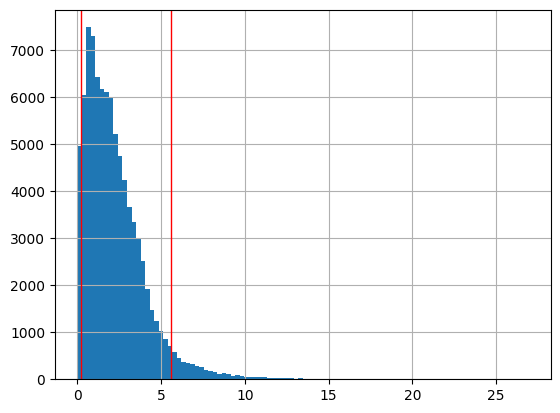

In [ ]:
# Calcolo dei percentili per le variabili di precipitazioni
percentile_95_piogge = df_pivot["Precipitazioni medie mensili"].quantile(0.95)
percentile_05_piogge = df_pivot["Precipitazioni medie mensili"].quantile(0.05)

# Visualizzazione dei dati per i percentili di precipitazioni
df_pivot["Precipitazioni medie mensili"].hist(bins=100)
plt.axvline(percentile_95_piogge, color='red', linewidth=1)
plt.axvline(percentile_05_piogge, color='red', linewidth=1)
plt.show()

# Creazione delle colonne per identificare grandi piogge e siccità
df_pivot["Grandi_piogge"] = (df_pivot["Precipitazioni medie mensili"] > percentile_95_piogge).astype(int)
df_pivot["Siccità"] = (df_pivot["Precipitazioni medie mensili"] < percentile_05_piogge).astype(int)

# Aggregazione dei dati per unità territoriale e anno
df_pivot_aggregato = df_pivot.groupby(["Nome_Unità_Territoriale", "Anno"])[["Grandi_piogge", "Siccità"]].sum().reset_index()

# Rimuozione delle colonne già esistenti
df_pivot = df_pivot.drop(columns=["Grandi_piogge", "Siccità"])

# Unione del dataset aggregato con il dataset originale
df_pivot = pd.merge(df_pivot, df_pivot_aggregato[["Nome_Unità_Territoriale", "Anno", "Grandi_piogge", "Siccità"]],
                    on=["Nome_Unità_Territoriale", "Anno"], how="left")

Indice temperature estreme annuali

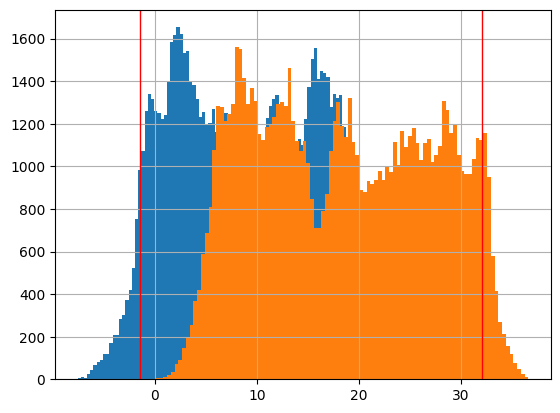

In [ ]:
# Calcolo dei percentili per le variabili di temperatura e precipitazioni
percentile_95_temp = df_pivot["Temperatura massima media mensile"].quantile(0.95)
percentile_05_temp = df_pivot["Temperatura minima media mensile"].quantile(0.05)

df_pivot["Temperatura minima media mensile"].hist(bins=100)
plt.axvline(percentile_05_temp, color='red', linewidth=1)
df_pivot["Temperatura massima media mensile"].hist(bins=100)
plt.axvline(percentile_95_temp, color='red', linewidth=1)
plt.show()

# Creazione delle colonne per i mesi caldi, freddi e piovosi
df_pivot["Mesi_caldi"] = (df_pivot["Temperatura massima media mensile"] > percentile_95_temp).astype(int)
df_pivot["Mesi_freddi"] = (df_pivot["Temperatura minima media mensile"] < percentile_05_temp).astype(int)


# Aggregazione dei dati per unità territoriale e anno
df_pivot_aggregato = df_pivot.groupby(["Nome_Unità_Territoriale", "Anno"])[["Mesi_caldi", "Mesi_freddi"]].sum().reset_index()

# Rimuozione delle colonne già esistenti
df_pivot = df_pivot.drop(columns=["Mesi_caldi", "Mesi_freddi"])

# Unione del dataset aggregato con il dataset originale
df_pivot = pd.merge(df_pivot, df_pivot_aggregato[["Nome_Unità_Territoriale", "Anno", "Mesi_caldi", "Mesi_freddi"]],
                    on=["Nome_Unità_Territoriale", "Anno"], how="left")

Tasso di mortalità 65+

In [ ]:
def calcola_decessi65(df_pivot):
    # Calcolo dei decessi annuali per ogni unità territoriale
    df_decessi = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Decessi 65+'].sum().reset_index()
    df_decessi.rename(columns={'Decessi 65+': 'Decessi 65+ annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot = calcola_decessi65(df_pivot)

def  calcolo_tasso_mortalita(df_pivot):

    df_decessi65 = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_decessi65 = df_decessi65.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata:
    df_decessi65['Tasso di mortalità 65+'] = (
    df_decessi65['Decessi 65+ annuale'].fillna(0)/
    ((df_decessi65['Percentuale pop anziana'] / 100) * df_decessi65['Popolazione residente totale di tutte le età']).replace(0, np.nan)
    ).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi65[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità 65+']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot =  calcolo_tasso_mortalita(df_pivot)

Tasso di mortalità 85+

In [ ]:
def calcola_decessi85(df_pivot):
    # Calcolo dei decessi annuali per ogni unità territoriale
    df_decessi = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Decessi 85+'].sum().reset_index()
    df_decessi.rename(columns={'Decessi 85+': 'Decessi 85+ annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot = calcola_decessi85(df_pivot)

def  calcolo_tasso_mortalita85(df_pivot):

    df_decessi85= df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_decessi85 = df_decessi85.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata:
    df_decessi85['Tasso di mortalità 85+'] = (
    df_decessi85['Decessi 85+ annuale'].fillna(0)/
    ((df_decessi85['Percentuale grandi anziani'] / 100) * df_decessi85['Popolazione residente totale di tutte le età']).replace(0, np.nan)
    * 100000).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_decessi85[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità 85+']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )
    return df_pivot

df_pivot =  calcolo_tasso_mortalita85(df_pivot)

Densità abitativa (annuale)

In [ ]:
# Colonna calcolata: "Densità abitativa"= Popolazione totale /'Superficie territoriale _kmq_
df_pivot['Densità abitativa'] = df_pivot['Popolazione residente totale di tutte le età'] / df_pivot['Superficie territoriale _kmq_ al 01/01/2023']

Tasso di incremento della popolazione (annuale)

In [ ]:
def calcola_tasso_incremento(df_pivot):

    df_annuale = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale = df_annuale.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata: "Tasso di incremento della popolazione": [pop tot (t) - pop tot (t-1)] / pop tot (t-1)
    df_annuale['Tasso di incremento della popolazione %'] = df_annuale.groupby('Nome_Unità_Territoriale')['Popolazione residente totale di tutte le età'].transform(
        lambda x: x.pct_change()
    )
    df_annuale['Tasso di incremento della popolazione %'] = df_annuale['Tasso di incremento della popolazione %'] * 100

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale[['Anno', 'Nome_Unità_Territoriale', 'Tasso di incremento della popolazione %']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_incremento(df_pivot)

Tasso di natalità (annuale)

In [ ]:
def calcola_tasso_natalita(df_pivot):

    # dati aggregati annuali per ogni unità territoriale
    df_natalità = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale']).agg({
        'Nati totali': 'sum',
        'Popolazione residente totale di tutte le età': 'mean'  # Usa la media della popolazione
    }).reset_index()

    # Calcolo del tasso di natalità annuale
    df_natalità['Tasso di natalità %'] = (
        df_natalità['Nati totali'] / df_natalità['Popolazione residente totale di tutte le età'] * 100
    ).round(2)

    # Merge del valore calcolato nel DataFrame originale
    df_pivot = df_pivot.merge(
        df_natalità[['Anno', 'Nome_Unità_Territoriale', 'Tasso di natalità %']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_natalita(df_pivot)

Tasso di mortalità (annuale)

In [ ]:
def calcola_tasso_mortalita(df_pivot):
    # Calcola i dati aggregati annuali per ogni unità territoriale
    df_mortalità = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale']).agg({
        'Decessi totali': 'sum',
        'Popolazione residente totale di tutte le età': 'mean'  # Usa la media della popolazione
    }).reset_index()

    # Calcola del tasso di martalità annuale
    df_mortalità['Tasso di mortalità %'] = (
        df_mortalità['Decessi totali'] / df_mortalità['Popolazione residente totale di tutte le età'] * 100
    ).round(2)

    # Merge del valore calcolato nel DataFrame originale
    df_pivot = df_pivot.merge(
        df_mortalità[['Anno', 'Nome_Unità_Territoriale', 'Tasso di mortalità %']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_tasso_mortalita(df_pivot)

In [ ]:
df_pivot = df_pivot.drop(columns=['Decessi 85+ annuale', 'Decessi 65+ annuale', 'Decessi totali'])

Temperatura media (annuale)

In [ ]:
def calcola_temperatura(df_pivot):
    # Calcolo della temperatura media annuale per ogni unità territoriale
    df_temp_annuale = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura media mensile'].mean().round(2).reset_index()
    df_temp_annuale.rename(columns={'Temperatura media mensile': 'Temperatura media annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_temperatura(df_pivot)

Variazione temperatura media (annuale)

In [ ]:
def  calcola_delta_temperatura(df_pivot):

    df_annuale = df_pivot.drop_duplicates(['Anno', 'Nome_Unità_Territoriale'])
    df_annuale = df_annuale.sort_values(['Anno', 'Nome_Unità_Territoriale'])

    # Colonna calcolata:
    df_annuale['Incremento temperatura media annuale'] = df_annuale.groupby('Nome_Unità_Territoriale')['Temperatura media annuale'].transform(
        lambda x: x.diff()
    ).round(2)

    # Merge del tasso di incremento sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_annuale[['Anno', 'Nome_Unità_Territoriale', 'Incremento temperatura media annuale']],
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot =  calcola_delta_temperatura(df_pivot)


In [ ]:
# Filtra solo i dati relativi all'anno 2018
df_2018 = df_pivot[df_pivot['Anno'] == 2018]

# Raggruppa per 'Nome_Unità_Territoriale' e 'Anno', mantenendo la variazione di temperatura
df_grouped = df_2018.groupby(['Nome_Unità_Territoriale', 'Anno'])[['Incremento temperatura media annuale']].mean().reset_index()

# Ordina per 'Incremento temperatura media annuale' in ordine decrescente
df_ordinato = df_grouped.sort_values(by='Incremento temperatura media annuale', ascending=False)

# Stampa il risultato
print(df_ordinato)

    Nome_Unità_Territoriale  Anno  Incremento temperatura media annuale
118               FISCAGLIA  2018                                  0.89
147       JOLANDA DI SAVOIA  2018                                  0.87
89                 CODIGORO  2018                                  0.84
200               OSTELLATO  2018                                  0.79
191                 MONZUNO  2018                                  0.78
..                      ...   ...                                   ...
297                TREDOZIO  2018                                 -0.47
224               PREDAPPIO  2018                                 -0.48
88     CIVITELLA DI ROMAGNA  2018                                 -0.49
239      ROCCA SAN CASCIANO  2018                                 -0.53
167                 MELDOLA  2018                                 -1.00

[321 rows x 3 columns]


Temperatura minima media (annuale)

In [ ]:
def calcola_temperatura_min(df_pivot):

    df_temp_annuale_min = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura minima media mensile'].mean().round(2).reset_index()
    df_temp_annuale_min.rename(columns={'Temperatura minima media mensile': 'Temperatura minima media annuale'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale_min,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot = calcola_temperatura_min(df_pivot)

Temperatura massima media (annuale)

In [ ]:
def calcola_temperatura_max(df_pivot):
    # Calcola la temperatura massima media annuale per ogni Anno e Unità Territoriale
    df_temp_annuale_max = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura massima media mensile'].mean().round(2).reset_index()

    # Crea una nuova colonna con il nome corretto senza sovrascrivere la colonna originale
    df_temp_annuale_max['Temperatura massima media annuale'] = df_temp_annuale_max['Temperatura massima media mensile']

    # Rinominare la colonna per evitare conflitti
    df_temp_annuale_max = df_temp_annuale_max.rename(columns={'Temperatura massima media mensile': 'Temperatura massima media mensile_annuale'})

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
        df_temp_annuale_max,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot, df_temp_annuale_max  # Restituisce entrambi i DataFrame

# Chiamata della funzione e assegnazione delle variabili
df_pivot, df_temp_annuale_max = calcola_temperatura_max(df_pivot)

# Crea una nuova variabile ordinata senza sovrascrivere df_temp_annuale_max
df_temp_annuale_max_sorted = df_temp_annuale_max.sort_values(by='Temperatura massima media annuale', ascending=False)

# Stampa i risultati
print(df_temp_annuale_max_sorted[['Nome_Unità_Territoriale', 'Temperatura massima media annuale']])


     Nome_Unità_Territoriale  Temperatura massima media annuale
7306                 RUBIERA                              21.64
7627                 RUBIERA                              21.56
7277         POGGIO RENATICO                              21.56
7315   SAN FELICE SUL PANARO                              21.54
7321      SAN MARTINO IN RIO                              21.53
...                      ...                                ...
316                 VOGHIERA                                NaN
317                    ZERBA                                NaN
318         ZIANO PIACENTINO                                NaN
319                    ZOCCA                                NaN
320             ZOLA PREDOSA                                NaN

[7704 rows x 2 columns]


Temperatura massima media dei massimi (annuali)

In [ ]:
def calcola_temperatura_max_media(df_pivot):
    # Trova il massimo della temperatura massima media mensile per ogni Anno e Unità Territoriale
    df_temp_annuale_max = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Temperatura massima media mensile'].max().reset_index()

    # Calcola la media dei valori massimi annuali per ogni Unità Territoriale
    df_media_max_anni = df_temp_annuale_max.groupby('Nome_Unità_Territoriale')['Temperatura massima media mensile'].mean().round(2).reset_index()

    # Crea una nuova colonna con il valore calcolato
    df_media_max_anni.rename(columns={'Temperatura massima media mensile': 'Temperature massime annuali'}, inplace=True)

    # Merge per riportare il valore lungo la colonna del DataFrame originale
    df_pivot = df_pivot.merge(df_media_max_anni, on='Nome_Unità_Territoriale', how='left')

    return df_pivot, df_media_max_anni  # Restituisce entrambi i DataFrame

# Chiamata della funzione e assegnazione delle variabili
df_pivot, df_media_max_anni = calcola_temperatura_max_media(df_pivot)

# Ordina le unità territoriali in base alla Temperature massime annuali
df_media_max_anni_sorted = df_media_max_anni.sort_values(by='Temperature massime annuali', ascending=False)

# Stampa i risultati
print(df_media_max_anni_sorted[['Nome_Unità_Territoriale', 'Temperature massime annuali']])

    Nome_Unità_Territoriale  Temperature massime annuali
76   CASTELVETRO PIACENTINO                        33.14
253   SAN FELICE SUL PANARO                        33.11
247          SALA BOLOGNESE                        33.10
267    SANT'AGATA BOLOGNESE                        33.09
68      CASTELFRANCO EMILIA                        33.09
..                      ...                          ...
303                VENTASSO                        24.60
317                   ZERBA                        24.41
176     MONCHIO DELLE CORTI                        24.03
119                FIUMALBO                        23.29
212             PIEVEPELAGO                        23.29

[321 rows x 2 columns]


Precipitazioni in mm (annuali)

In [ ]:
def calcola_precipitazioni(df_pivot):

    df_precipitazioni = df_pivot.groupby(['Anno', 'Nome_Unità_Territoriale'])['Precipitazioni medie mensili'].sum().round(2).reset_index()
    df_precipitazioni.rename(columns={'Precipitazioni medie mensili': 'Precipitazioni medie annuali'}, inplace=True)

    # Merge del valore calcolato sul DataFrame originale
    df_pivot = df_pivot.merge(
       df_precipitazioni,
        on=['Anno', 'Nome_Unità_Territoriale'],
        how='left'
    )

    return df_pivot

df_pivot =calcola_precipitazioni(df_pivot)

Spopolamento

In [ ]:
# Filtro dei dati per il 2004 e il 2023 mantenendo tutte le colonne
df_2004 = df_pivot[df_pivot['Anno'] == 2004]
df_2023 = df_pivot[df_pivot['Anno'] == 2023]

# Raggruppamento per 'Nome_Unità_Territoriale'
df_pop_2004 = df_2004.groupby(['Nome_Unità_Territoriale'])['Popolazione residente totale di tutte le età'].mean().reset_index()
df_pop_2023 = df_2023.groupby(['Nome_Unità_Territoriale'])['Popolazione residente totale di tutte le età'].mean().reset_index()

# Calcolo della differenza percentuale di popolazione tra il 2004 e il 2023
df_pop = df_pop_2004.merge(df_pop_2023, on='Nome_Unità_Territoriale', suffixes=('_2004', '_2023'))
df_pop['Spopolamento % 2004-2023'] = ((df_pop['Popolazione residente totale di tutte le età_2004'] - df_pop['Popolazione residente totale di tutte le età_2023']) /
                          df_pop['Popolazione residente totale di tutte le età_2004'] * 100).round(0)

df_pivot = df_pivot.merge(df_pop[['Nome_Unità_Territoriale', 'Spopolamento % 2004-2023']],
                             on=['Nome_Unità_Territoriale'],
                             how='left')

## Arrotondamento dei valori

In [ ]:
columns_to_round_0 = [ 'Altitudine del centro _metri_','Grado di urbanizzazione','Densità abitativa',
                      'Percentuale grandi anziani','Percentuale pop anziana','Percentuale pop giovanile','Percentuale pop in età lavorativa']

columns_to_round_2 = [
    "Tasso di incremento della popolazione %",
    "% Edifici residenziali con stato di conservazione buono",
    "% Edifici residenziali con stato di conservazione medio",
    "% Edifici residenziali con stato di conservazione ottimo",
    "% Edifici residenziali con stato di conservazione pessimo",
    "% Aree a Pericolosità idraulica bassa",
    "% Aree a Pericolosità idraulica media",
    "% Aree a Pericolosità idraulica elevata",
    "Quota di edifici residenziali costruiti prima del 1981 _%_",
    "Quota di edifici residenziali costruiti tra il 1981-2005 _%_",
    "% Area a Pericolosità da frana PAI elevata",
    "% Area a Pericolosità da frana PAI media",
    "% Area a Pericolosità da frana PAI moderata",
    "% Area a Pericolosità da frana PAI molto elevata",
    "% Area a Pericolosità da frana PAI molto elevata e elevata",
]

# Arrotondamenti a 0,1,2 cifre decimali
df_pivot[columns_to_round_0] = df_pivot[columns_to_round_0].apply(lambda x: x.round(0))
df_pivot[columns_to_round_2] = df_pivot[columns_to_round_2].apply(lambda x: x.round(2))

## Ridenominazione colonne

In [ ]:
#df_pivot.columns

In [ ]:
# Dizionario di mappatura vecchio_nome: nuovo_nome
mapping_colonne = {
        "Età media totale": "Età media",
        "Altitudine del centro _metri_": "Altitudine (m)",
        "Percentuale grandi anziani": "% grandi anziani",
        "Percentuale pop anziana": "% pop anziana",
        "Percentuale pop giovanile": "% pop giovanile",
        "Percentuale pop in età lavorativa": "% pop in età lavorativa",
        "Popolazione di età compresa fra 25 e 64 anni con titolo di studio non oltre la licenza di scuola media inferiore o di avviamento professionale": "% pop 25-64 con licenza media",
        "Popolazione residente totale di tutte le età": "Popolazione totale",
        'Quota di edifici residenziali costruiti dopo il 2005  _%_': "% Edifici residenziali costruiti dopo il 2005",
        "Quota di edifici residenziali costruiti tra il 1981-2005 _%_": "% Edifici residenziali costruiti tra il 1981-2005",
        "Quota di edifici residenziali costruiti prima del 1981 _%_": "% Edifici residenziali costruiti prima del 1981",
        "Superficie territoriale _kmq_ al 01/01/2023": "Superficie territoriale (kmq)",
        "Indice composito di fragilità comunale - _decile_":"Indice di fragilità (decile)",
        "Valore massimo dell'accelerazione massima del suolo  dei valori dei punti della griglia ricadenti nel territorio comunale": "Valore massimo dell'accelerazione del suolo"
    }

# Rinominazione delle colonne usando il mapping
df_pivot = df_pivot.rename(columns=mapping_colonne)
#df_pivot.columns

## Rimozione dati prima del 2004

In [ ]:
# Considerazione solo delle righe che hanno Anno >= 2004
df_pivot = df_pivot[df_pivot['Anno'] >= 2004]

## Esportazione Dataset pulito

In [ ]:
#facoltativo
df_pivot.to_csv('/content/drive/My Drive/Data4Resilience_mio/df_pulito.csv', index=False)

# Parte 2 : Analisi Dataset

## Caricamento Dataset Pulito

In [ ]:
#se è stato esportato df_pivot
file_path = '/content/drive/My Drive/Data4Resilience_mio/df_pulito.csv'
df_pulito = pd.read_csv(file_path)

#altimenti: df_pulito = df_pivot

In [ ]:
#Informazioni sul dataset:
#df_pulito.info()

## Creazione liste di variabili

### Selezione Variabili numeriche

In [ ]:
variabili_numeriche = df_pulito.select_dtypes(include=['float64', 'int64']).columns.tolist()
variabili_numeriche = [col for col in variabili_numeriche if col not in ['Anno', 'Mese']]

### Selezione Variabili ambientali

In [ ]:
variabili_ambientali = [
     "Valore massimo dell'accelerazione del suolo",
                        'Altitudine (m)',
                        'Precipitazioni medie annuali',
                        'Incremento temperatura media annuale',
                        'Temperature massime annuali',
                        'Escursione termica',
                        '% Aree a Pericolosità idraulica elevata',
                        'Superficie territoriale (kmq)',
                        '% Area a Pericolosità da frana PAI molto elevata e elevata',
                       ]

### Selezione Variabili socio-demografiche

In [ ]:
variabili_demografiche = ['Popolazione totale', 'Consumo del suolo', 'Età media','% pop anziana',
                          '% Edifici residenziali costruiti dopo il 2005',
                          '% Edifici residenziali con stato di conservazione pessimo',
                          'Densità abitativa', 'Tasso di natalità %',
                          'Tasso di mortalità %','Spopolamento % 2004-2023']


## Creazione Dataframe utili

### Creazione Dataframe annuale

In [ ]:
df_annuale = df_pulito.copy()
df_annuale = df_annuale.drop(columns=['Mese'])

# Calcolo della media solo per le colonne numeriche
df_imputed = df_annuale.groupby(['Nome_Unità_Territoriale', 'Anno'])[variabili_numeriche].mean().reset_index()

# Riempimento dei NaN con il valore medio per 'Nome_Unità_Territoriale'
df_annuale[variabili_numeriche] = df_annuale.groupby('Nome_Unità_Territoriale')[variabili_numeriche].transform(lambda x: x.fillna(x.mean()))


### Creazione Dataframe comunale

In [ ]:
# Rimuozione della colonna 'Anno' da df_annuale
df_comuni = df_annuale.drop('Anno', axis=1)

# Raggruppamento per 'Nome Unità Territoriale'
df_comuni = df_comuni.groupby('Nome_Unità_Territoriale')[variabili_numeriche].mean().reset_index()

## Cluster Analysis

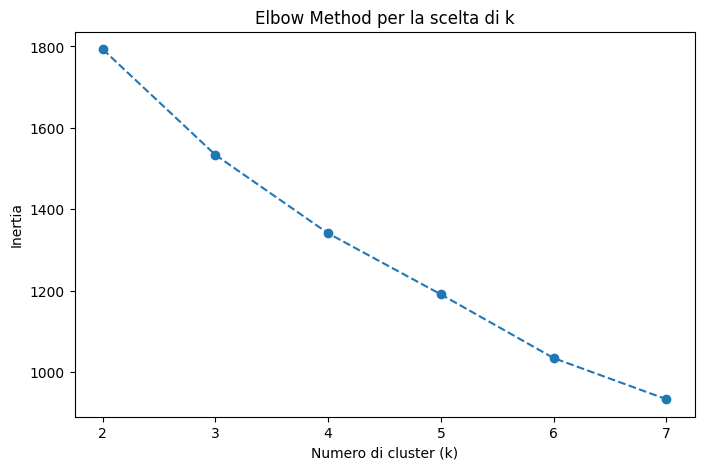

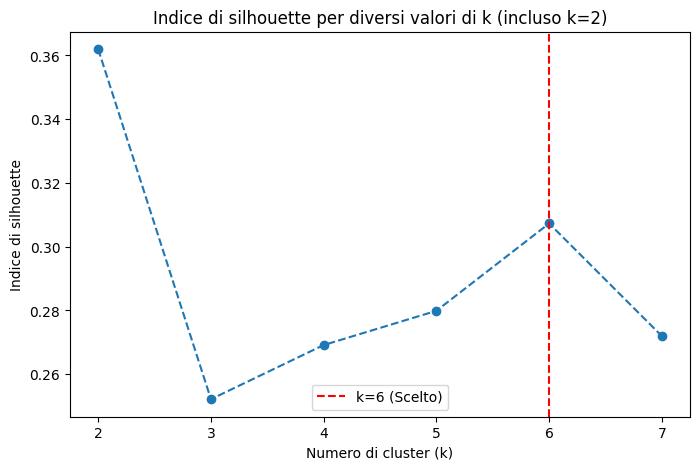

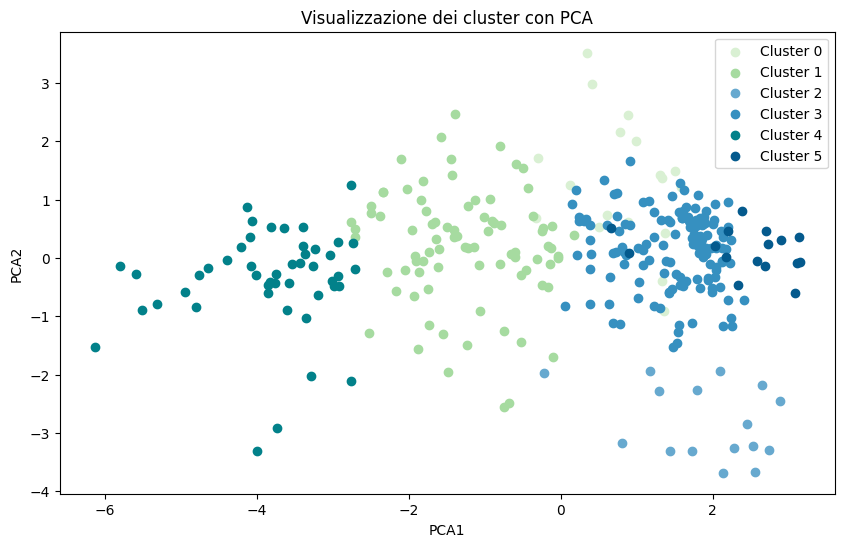

In [ ]:
# Aggregazione per unità territoriale (media nel tempo)
df_climatico = df_pulito.groupby('Nome_Unità_Territoriale')[variabili_ambientali].mean().reset_index()

# Standardizzazione dei dati
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_climatico.iloc[:, 1:])

# Elbow Method per determinare il numero ottimale di cluster (escludendo k=2)
inertia = []
max_k = 8
k_range = range(2, max_k)  # Inizia da k=2 per includerlo nel grafico

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# Visualizzazione Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method per la scelta di k')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Inertia')
plt.show()

# Silhouette Score per determinare il numero ottimale di cluster
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    score = silhouette_score(df_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Visualizzazione Silhouette Score, includendo k=2 ma evidenziando la scelta
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
best_k = max(range(3, max_k), key=lambda k: silhouette_scores[k-2])  # Selezione di k che massimizza l'indice di silhouette (escludendo k=2)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'k={best_k} (Scelto)')
plt.title('Indice di silhouette per diversi valori di k (incluso k=2)')
plt.xlabel('Numero di cluster (k)')
plt.ylabel('Indice di silhouette')
plt.legend()
plt.show()

# Applicare KMeans con il numero ottimale di cluster
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)  # Usa il miglior k basato sull'indice di silhouette
df_climatico['cluster'] = kmeans.fit_predict(df_scaled)

# Riduzione della dimensionalità con PCA per visualizzazione
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)
df_climatico['PCA1'] = pca_result[:, 0]
df_climatico['PCA2'] = pca_result[:, 1]

# Lista dei colori
color_list = ["#D9F0D3", "#A6DBA0", "#67A9CF", "#3690C0", "#02818A", "#045A8D"]

# Scatter plot dei cluster con i colori definiti
plt.figure(figsize=(10, 6))
for cluster in range(best_k):
    subset = df_climatico[df_climatico['cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', color=color_list[cluster])

plt.title('Visualizzazione dei cluster con PCA')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()


In [ ]:
# Numerosità per ciascun cluster
cluster_sizes = df_climatico.groupby('cluster').size()
print(cluster_sizes)

cluster
0     19
1     84
2     16
3    139
4     47
5     16
dtype: int64


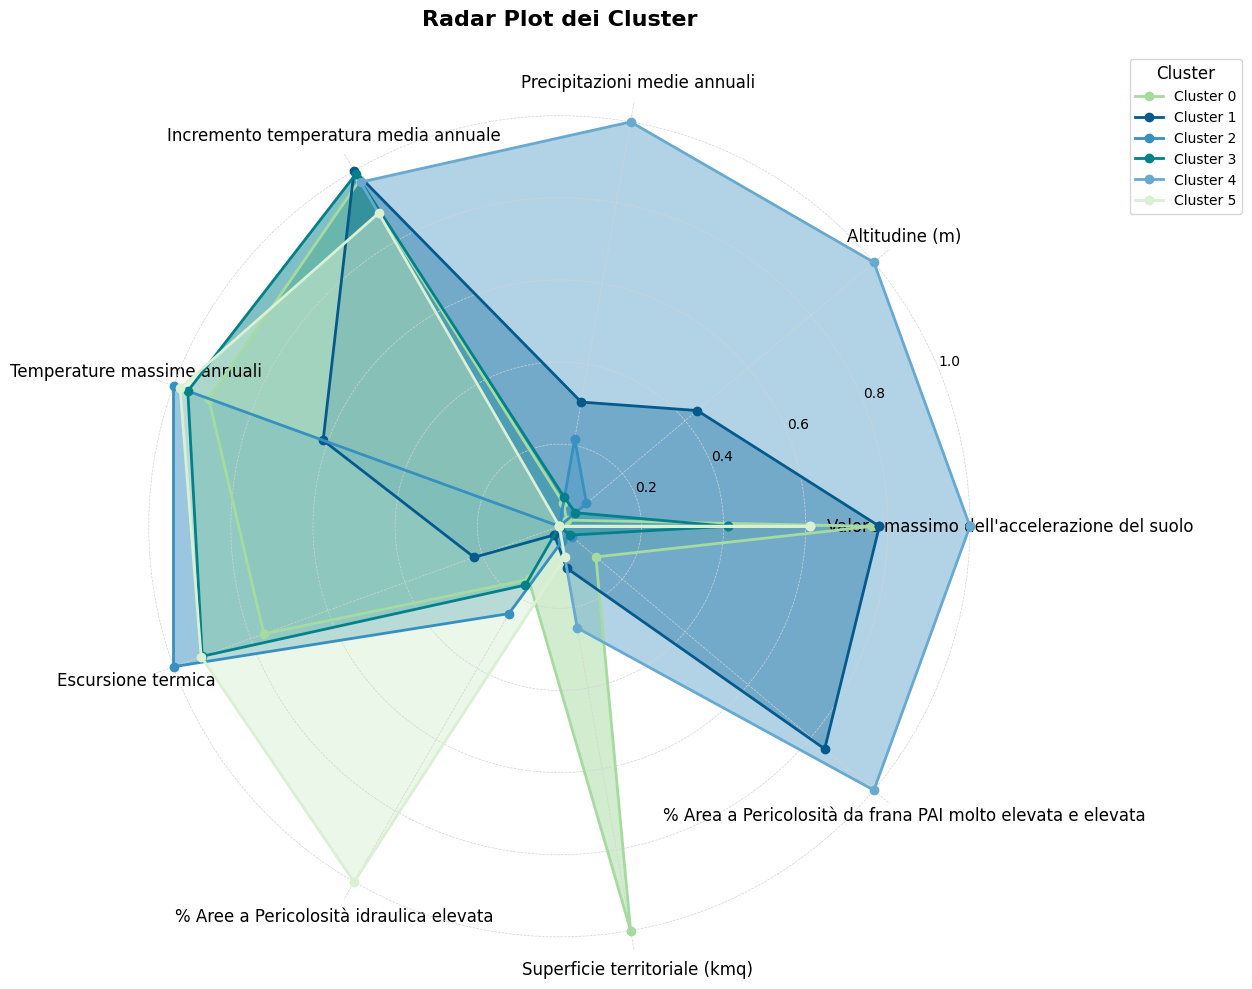

In [ ]:
# Definizione dei colori
color_list = ["#A6DBA0","#045A8D" , "#3690C0", "#02818A", "#67A9CF" ,"#D9F0D3"]

# Statistiche descrittive per ogni cluster
clusters_stats = df_climatico.groupby('cluster')[variabili_ambientali].mean()

# Creazione degli angoli per il radar plot
angles = np.linspace(0, 2 * np.pi, len(variabili_ambientali), endpoint=False).tolist()
angles.append(angles[0])  # Chiudiamo il cerchio

# Normalizzazione dei dati con MinMaxScaler
scaler = MinMaxScaler()
means_normalized = scaler.fit_transform(clusters_stats)

# Numero di cluster
num_clusters = len(clusters_stats)

# Creazione del grafico radar
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(polar=True))

# Disegnamo i dati di ogni cluster con i colori specificati
for cluster in range(num_clusters):
    cluster_data = means_normalized[cluster].tolist()
    cluster_data.append(cluster_data[0])  # Chiudiamo il cerchio

    ax.plot(angles, cluster_data, label=f'Cluster {cluster}', marker='o', linestyle='-',
            linewidth=2, color=color_list[cluster])
    ax.fill(angles, cluster_data, color=color_list[cluster], alpha=0.50)  # Opacità più chiara

# Titolo del grafico
ax.set_title('Radar Plot dei Cluster', fontsize=16, fontweight='bold', pad=50)

# Etichette degli assi (variabili ambientali)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(variabili_ambientali, fontsize=12, rotation=45)

# Aggiunta di linee di griglia leggere
ax.yaxis.grid(True, color="lightgray", linestyle='--', linewidth=0.5)
ax.xaxis.grid(True, color="lightgray", linestyle='--', linewidth=0.5)

# Rimozione del bordo circolare
ax.spines['polar'].set_visible(False)

# Legenda
plt.legend(title='Cluster', bbox_to_anchor=(1.3, 1.05), fontsize=10, title_fontsize=12)

# Miglioriamo la disposizione
plt.tight_layout()
plt.show()


In [ ]:
# Numerosità per ciascun cluster
cluster_sizes = df_climatico.groupby('cluster').size()
print(cluster_sizes)

cluster
0     19
1     84
2     16
3    139
4     47
5     16
dtype: int64


Test ANOVA per capire quali variabili (climatiche e demografiche) sono significativamente diverse tra i Cluster

In [ ]:
# Merge tra df_annuale e df_climatico
df_annuale = df_annuale.merge(df_climatico[['Nome_Unità_Territoriale', 'cluster']], on='Nome_Unità_Territoriale', how='left')

In [ ]:
# Funzione per eseguire l'ANOVA e stampare i risultati
def run_anova(variable_list, category_name):
    print(f"\n{'-'*40}\nTest ANOVA per le variabili {category_name}:\n{'-'*40}")
    for variable in variable_list:
        groups = [df_annuale[df_annuale['cluster'] == cluster][variable] for cluster in df_annuale['cluster'].unique()]
        f_statistic, p_value = f_oneway(*groups)

        # Risultati
        print(f"\nTest ANOVA per {variable}:")
        print(f"F-statistic: {f_statistic}")
        print(f"P-value: {p_value}")

        # Interpretazione
        if p_value < 0.05:
            print(f" Le medie per \033[1m{variable}\033[0m sono significativamente diverse tra i cluster.")
        else:
            print(f"Le medie per {variable} NON sono significativamente diverse tra i cluster.")

# Esegui l'ANOVA per le variabili climatiche
#run_anova(variabili_ambientali, "Ambientali")

# Esegui l'ANOVA per le variabili demografiche
#run_anova(variabili_demografiche, "Demografiche")

print("Il test ANOVA ha restituito un valore di p < 0.05 per tutte le variabili, indicando che esistono differenze statisticamente significative tra i cluster.")

Il test ANOVA ha restituito un valore di p < 0.05 per tutte le variabili, indicando che esistono differenze statisticamente significative tra i cluster.


### Statistiche descrittive

In [ ]:
# Merge tra df_pulito e df_climatico
df_pulito = df_pulito.merge(df_climatico[['Nome_Unità_Territoriale', 'cluster']], on='Nome_Unità_Territoriale', how='left')

In [ ]:
# Tabelle con statistiche descrittive
socio_demografiche_tab = df_pulito.groupby('cluster')[variabili_demografiche].mean().round(2)
ambientali_tab = df_pulito.groupby('cluster')[variabili_ambientali].mean().round(2)

descrittive_socio_demografiche = df_pulito[variabili_demografiche].describe().round(2)
descrittive_ambientali = df_pulito[variabili_ambientali].describe().round(2)

In [ ]:
# Download Word con tabelle
doc = Document()

# Funzione per aggiungere una tabella Pandas a un documento Word
def aggiungi_tabella(doc, df, titolo):
    doc.add_paragraph(titolo, style="Heading 2")

    # Se il DataFrame ha un indice significativo, lo resettiamo per conservarlo come colonna
    if df.index.name:
        df = df.reset_index()
    else:
        df = df.reset_index(drop=False)  # Mantiene l'indice anche se non ha nome

    table = doc.add_table(rows=df.shape[0] + 1, cols=df.shape[1])  # Crea tabella
    table.style = 'Table Grid'  # Stile tabella

    # Aggiunge le intestazioni
    for j, col_name in enumerate(df.columns):
        table.cell(0, j).text = str(col_name)

    # Aggiunge le righe di dati
    for i, row in enumerate(df.itertuples(index=False), start=1):
        for j, value in enumerate(row):
            table.cell(i, j).text = str(value)

    doc.add_paragraph("\n")  # Spazio tra le tabelle

# Salvataggio delle tabelle nel documento Word
aggiungi_tabella(doc, socio_demografiche_tab, "Statistiche socio-demografiche per cluster")
aggiungi_tabella(doc, ambientali_tab, "Statistiche ambientali per cluster")
aggiungi_tabella(doc, descrittive_socio_demografiche, "Statistiche descrittive socio-demografiche")
aggiungi_tabella(doc, descrittive_ambientali, "Statistiche descrittive ambientali")

# Salvataggio file Word
doc.save("statistiche_descrittive.docx")

# Parte 3: Domande di ricerca

## 1. Quali fattori ambientali caratterizzano le aree soggette a spopolamento?

### Modello semplice

In [ ]:
# Vettore di covariate
X = df_comuni[variabili_ambientali]
X = sm.add_constant(X)

In [ ]:
y_spop = df_comuni['Spopolamento % 2004-2023']

# Modello di regressione
model_spop = sm.OLS(y_spop, X).fit()

# Risultati del modello
print(model_spop.summary())

                               OLS Regression Results                               
Dep. Variable:     Spopolamento % 2004-2023   R-squared:                       0.479
Model:                                  OLS   Adj. R-squared:                  0.464
Method:                       Least Squares   F-statistic:                     31.73
Date:                      Wed, 19 Mar 2025   Prob (F-statistic):           3.39e-39
Time:                              10:46:15   Log-Likelihood:                -1236.2
No. Observations:                       321   AIC:                             2492.
Df Residuals:                           311   BIC:                             2530.
Df Model:                                 9                                         
Covariance Type:                  nonrobust                                         
                                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

### Modello ridotto

In [ ]:
# Eliminazione dal modello delle variabili non significative
X_spop = X.drop(columns=['Temperature massime annuali','% Area a Pericolosità da frana PAI molto elevata e elevata','% Aree a Pericolosità idraulica elevata'])

In [ ]:
# Calcolo del VIF per ogni variabile
vif_spop = pd.DataFrame()
vif_spop['Variabile'] = X_spop.columns
vif_spop['VIF'] = [variance_inflation_factor(X_spop.values, i) for i in range(X_spop.shape[1])]

# Risultati
print()
print('\033[1mVIF\033[0m')
print(vif_spop)


VIF
                                     Variabile         VIF
0                                        const  247.134828
1  Valore massimo dell'accelerazione del suolo    1.255241
2                               Altitudine (m)    3.119048
3                 Precipitazioni medie annuali    3.008176
4         Incremento temperatura media annuale    1.176413
5                           Escursione termica    2.253487
6                Superficie territoriale (kmq)    1.045600


In [ ]:
# Modello di regressione
modello_spop2 = sm.OLS(y_spop, X_spop).fit()

# Risultati del modello non lineare
print(modello_spop2.summary())

                               OLS Regression Results                               
Dep. Variable:     Spopolamento % 2004-2023   R-squared:                       0.410
Model:                                  OLS   Adj. R-squared:                  0.399
Method:                       Least Squares   F-statistic:                     36.37
Date:                      Wed, 19 Mar 2025   Prob (F-statistic):           2.24e-33
Time:                              10:46:15   Log-Likelihood:                -1256.0
No. Observations:                       321   AIC:                             2526.
Df Residuals:                           314   BIC:                             2552.
Df Model:                                 6                                         
Covariance Type:                  nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

#### Verifica delle assunzioni e diagnostica del modello

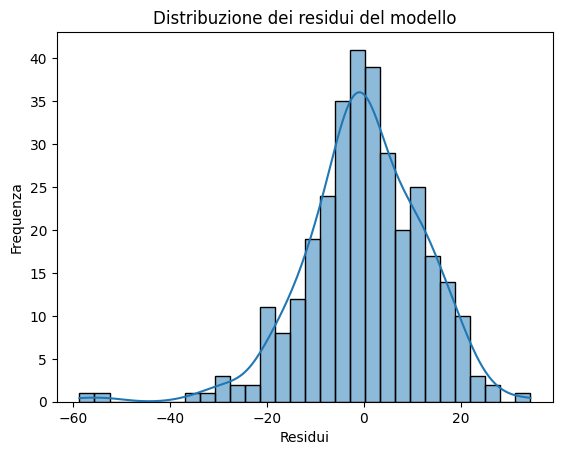

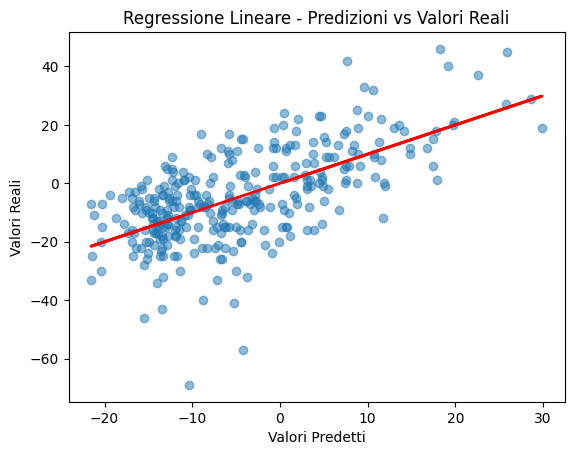

In [ ]:
# Visualizzazione della distribuzione dei residui
sns.histplot(modello_spop2.resid, bins=30, kde=True)
plt.xlabel("Residui")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei residui del modello")
plt.show()

# Scatter plot: Predizioni vs Valori reali
plt.scatter(modello_spop2.fittedvalues, y_spop, alpha=0.5)
plt.xlabel("Valori Predetti")
plt.ylabel("Valori Reali")
plt.title("Regressione Lineare - Predizioni vs Valori Reali")

# Calcolo della retta di regressione (linea dei minimi quadrati)
slope, intercept = np.polyfit(modello_spop2.fittedvalues, y_spop, 1)

# Retta di regressione
plt.plot(modello_spop2.fittedvalues, slope * modello_spop2.fittedvalues + intercept, color='red', linewidth=2)

plt.show()


Residui vs valori predetti


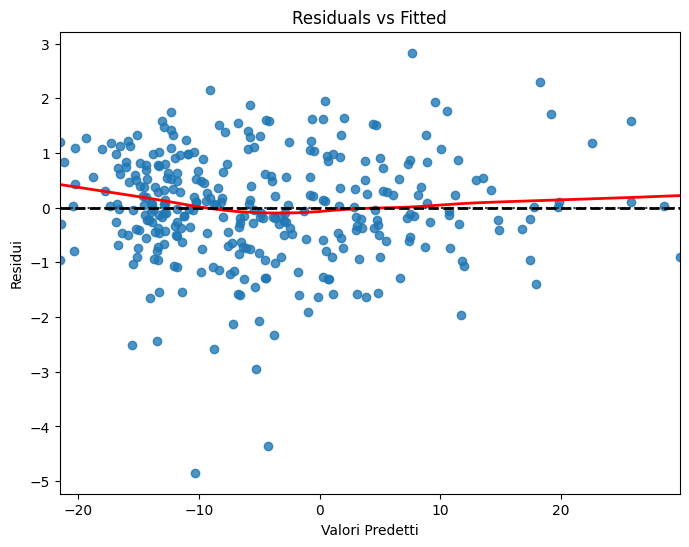

In [ ]:
residui = modello_spop2.resid

# Varianza dei residui
residui_std = np.std(residui)

# Residui studentizzati
residui_studentized = residui / residui_std

valori_predetti = modello_spop2.fittedvalues

plt.figure(figsize=(8,6))
sns.residplot(x=valori_predetti, y=residui_studentized, lowess=True, line_kws={"color": "red", "lw": 2})
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel("Valori Predetti")
plt.ylabel("Residui")
plt.title("Residuals vs Fitted")
plt.show()

Scale-location Plot

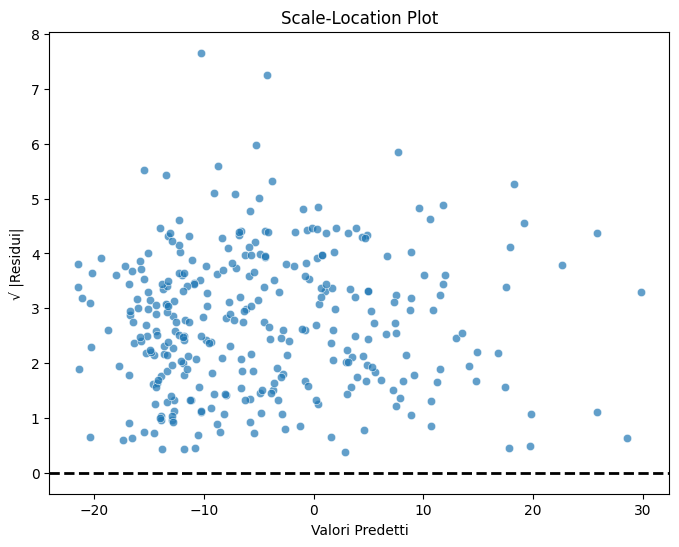

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=valori_predetti, y=np.sqrt(np.abs(residui)), alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel("Valori Predetti")
plt.ylabel("√ |Residui|")
plt.title("Scale-Location Plot")
plt.show()

Verifica Ouliers e punti di Leverage

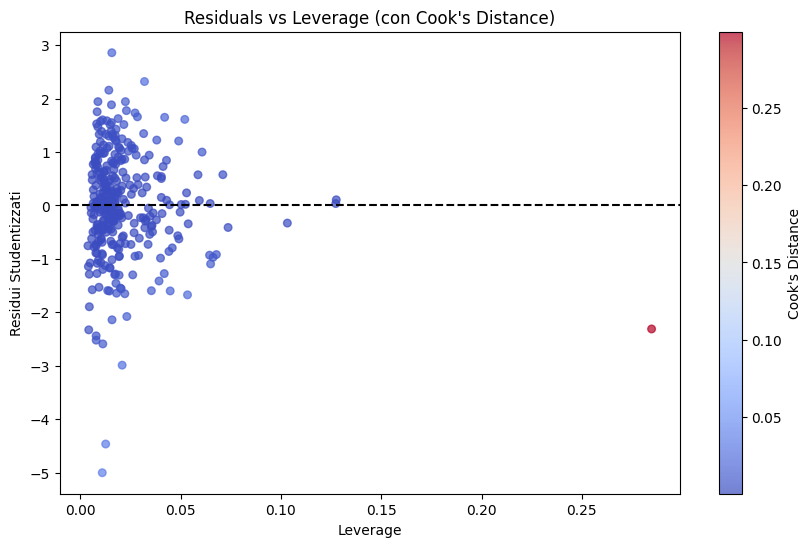

In [ ]:
# Leverage e i residui studentizzati
influence = modello_spop2.get_influence()
leverage = influence.hat_matrix_diag
resid_studentized = influence.resid_studentized_external
cooks_d = influence.cooks_distance[0]

# Soglia per identificare outliers basata sulla Cook's Distance
threshold_cooks = 4 / len(X)  # Formula per identificare outlier influenti
threshold_leverage = 2 * (X.shape[1] / len(X))  # Soglia per la leverage
threshold_resid = 3  # Outlier residui studentizzati oltre ±3

# Figura
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
sc = ax.scatter(leverage, resid_studentized, s=30, c=cooks_d, cmap='coolwarm', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='black', linewidth=1.5)

# Nuovo ciclo che mostra solo le etichette con leverage > threshold e residuo > 3
for i, (lev, res) in enumerate(zip(leverage, resid_studentized)):
    # Condizione per leverage > threshold e residuo > 3
    if lev > threshold_leverage and res > 3:
        ax.annotate(f'{i}', (lev, res), fontsize=9, color='black', xytext=(5, 5), textcoords='offset points')

# Titoli e etichette
plt.xlabel("Leverage")
plt.ylabel("Residui Studentizzati")
plt.title("Residuals vs Leverage (con Cook's Distance)")
cbar = plt.colorbar(sc)
cbar.set_label("Cook's Distance")

plt.show()


Normal Q-Q Plot

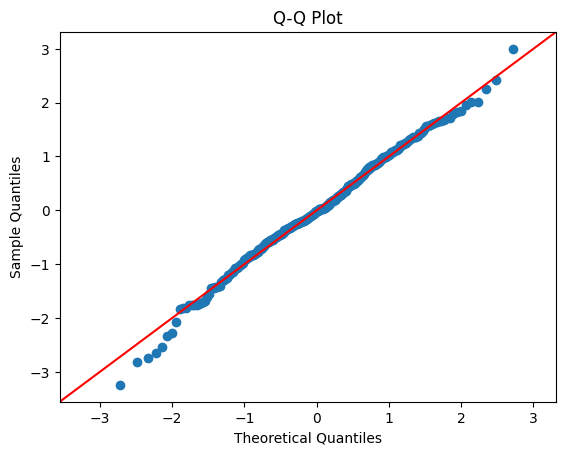

Statistic test: 0.9949751731088539, p-value: 0.4148688561460621
I residui seguono una distribuzione normale (non rifiutiamo H0).


In [ ]:
# Identificazione degli indici outlier
outlier_indices = np.where((np.abs(resid_studentized) > threshold_resid) | (leverage > threshold_leverage))[0]

# Filtrare i residui per rimuovere gli outlier
residui_clean = np.delete(resid_studentized, outlier_indices)

# QQ plot
sm.qqplot(residui_clean, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()


# Test di Shapiro-Wilk per la normalità dei residui studentizzati
stat, p_value = stats.shapiro(residui_clean)

print(f"Statistic test: {stat}, p-value: {p_value}")

# Interpretazione
if p_value > 0.05:
    print("I residui seguono una distribuzione normale (non rifiutiamo H0).")
else:
    print("I residui non seguono una distribuzione normale (rifiutiamo H0 del test Shapiro Wilk).")


## 2. In che modo l'età anziana della popolazione si collega allo stato degli edifici e alla vulnerabilità ambientale?

In [ ]:
# Filtro del dataset per il 2018
df_2018 = df_pulito[df_pulito['Anno'] == 2018]
df_2018 = df_2018.groupby('Nome_Unità_Territoriale')[variabili_numeriche].mean().reset_index()

### Matrice di correlazione

Correlazione di Pearson: 0.15 (p-value: 0.0071)
Correlazione di Spearman: 0.04 (p-value: 0.4829)


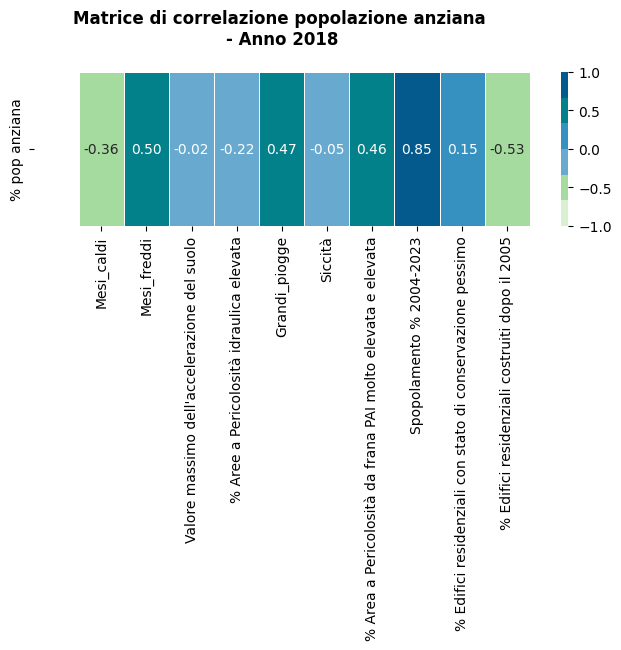

In [ ]:
# Correlazioni con % pop anziana
corr_pearson, p_pearson = pearsonr(df_2018['% pop anziana'], df_2018['% Edifici residenziali con stato di conservazione pessimo'])
corr_spearman, p_spearman = spearmanr(df_2018['% pop anziana'], df_2018['% Edifici residenziali con stato di conservazione pessimo'])

print(f"Correlazione di Pearson: {corr_pearson:.2f} (p-value: {p_pearson:.4f})")
print(f"Correlazione di Spearman: {corr_spearman:.2f} (p-value: {p_spearman:.4f})")

# Selezione delle colonne per calcolare la correlazione
df_2018_corr = df_2018[['% pop anziana','Mesi_caldi','Mesi_freddi',"Valore massimo dell'accelerazione del suolo",
            '% Aree a Pericolosità idraulica elevata', "Grandi_piogge","Siccità",'% Area a Pericolosità da frana PAI molto elevata e elevata', 'Spopolamento % 2004-2023',
            '% Edifici residenziali con stato di conservazione pessimo', '% Edifici residenziali costruiti dopo il 2005'
            ]]

# Definizione della scala cromatica personalizzata
custom_palette = ["#045A8D", "#02818A", "#3690C0", "#67A9CF", "#A6DBA0", "#D9F0D3"]
custom_palette = custom_palette[::-1]

# Matrice di correlazione
corr_matrix = df_2018_corr.corr()

# Impostare la correlazione tra '% pop anziana' e sé stessa a NaN
corr_matrix.iloc[0, 0] = None  # Prima riga, prima colonna (diagonale)

# Plot della prima riga senza la correlazione tra '% pop anziana' e '% pop anziana'
first_row = corr_matrix.iloc[0]

# Plot della prima riga
plt.figure(figsize=(8, 2))
sns.heatmap(first_row.to_frame().T, annot=True, cmap=sns.color_palette(custom_palette, as_cmap=True),
            fmt=".2f", linewidths=0.5, center=0, vmin=-1, vmax=1)

# Aggiungi il titolo in grassetto con padding
plt.title("Matrice di correlazione popolazione anziana \n- Anno 2018", pad=20, fontweight='bold')

# Rimuovi solo l'etichetta dell'asse x per '% pop anziana'
labels = first_row.index.tolist()
labels[0] = ''  # Rimuovi l'etichetta per la prima colonna ('% pop anziana')

# Impostiamo i tick centrati
num_columns = len(first_row)
tick_positions = [i + 0.5 for i in range(num_columns)]  # Spostiamo i tick al centro dei quadrati

# Impostiamo i tick centrati e rimuoviamo il primo tick
plt.xticks(ticks=tick_positions[1:], labels=labels[1:], ha='center')  # Rimuove il primo tick e l'etichetta

plt.show()


### Modello semplice

In [ ]:
X = df_2018[['Mesi_caldi','Mesi_freddi',"Valore massimo dell'accelerazione del suolo",
            '% Aree a Pericolosità idraulica elevata', "Grandi_piogge","Siccità",'% Area a Pericolosità da frana PAI molto elevata e elevata', 'Spopolamento % 2004-2023',
            '% Edifici residenziali con stato di conservazione pessimo', '% Edifici residenziali costruiti dopo il 2005'
            ]]
X = sm.add_constant(X)

y = df_2018['% pop anziana']

# Modello di regressione
modello_età = sm.OLS(y, X).fit()

# Risultati del modello
#print(modello_età.summary())

### Modello ridotto

In [ ]:
y_log_età = np.log(df_2018['% pop anziana']) # Logaritmo
y_sqrt = np.sqrt(df_2018['% pop anziana'])  # Radice quadrata

#Riduzione variabili
X_età = X.drop(columns=['% Aree a Pericolosità idraulica elevata','% Area a Pericolosità da frana PAI molto elevata e elevata','% Edifici residenziali con stato di conservazione pessimo',
                         '% Edifici residenziali costruiti dopo il 2005',"Valore massimo dell'accelerazione del suolo",
                        "Grandi_piogge"])

# Seleziona le variabili per le quali vuoi aggiungere il termine quadratico
variabili_quadratiche = ['Spopolamento % 2004-2023']

# Aggiungi termini quadratici solo per le variabili selezionate

for col in variabili_quadratiche:
    if col in X.columns:  # Verifica che la variabile esista in X
        X_età[f'{col}^2'] = X_età[col] ** 2

# Modello di regressione
modello_età_2 = sm.OLS(y_log_età, X_età).fit()

# Risultati del modello
print(modello_età_2.summary())

                            OLS Regression Results                            
Dep. Variable:          % pop anziana   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     316.0
Date:                Wed, 19 Mar 2025   Prob (F-statistic):          2.11e-120
Time:                        10:46:17   Log-Likelihood:                 330.58
No. Observations:                 321   AIC:                            -649.2
Df Residuals:                     315   BIC:                            -626.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
# Calcolo del VIF per ogni variabile
vif_età = pd.DataFrame()
vif_età['Variabile'] = X_età.columns
vif_età['VIF'] = [variance_inflation_factor(X_età.values, i) for i in range(X_età.shape[1])]

# Risultati
print()
print('\033[1mVIF\033[0m')
print(vif_età)


VIF
                    Variabile       VIF
0                       const  3.184138
1                  Mesi_caldi  1.180482
2                 Mesi_freddi  1.359011
3                     Siccità  1.022077
4    Spopolamento % 2004-2023  1.436427
5  Spopolamento % 2004-2023^2  1.134571


#### Verifica delle assunzioni e diagnostica del modello

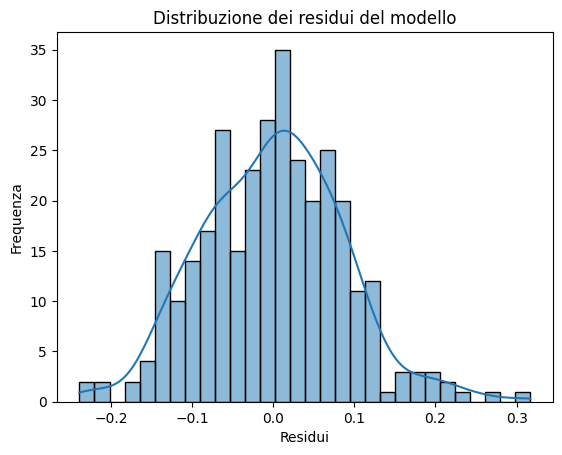

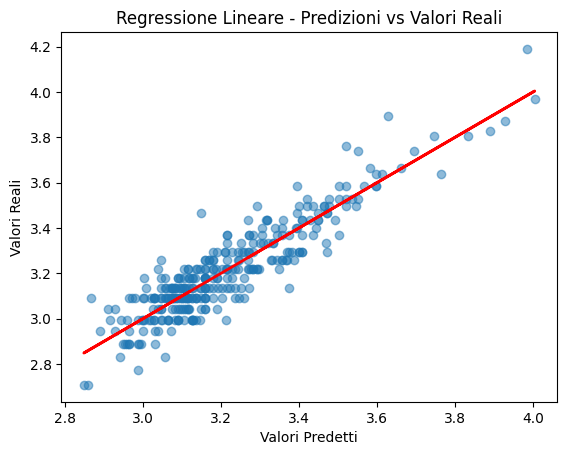

In [ ]:
# Visualizzazione della distribuzione dei residui
sns.histplot(modello_età_2.resid, bins=30, kde=True)
plt.xlabel("Residui")
plt.ylabel("Frequenza")
plt.title("Distribuzione dei residui del modello")
plt.show()

# Scatter plot: Predizioni vs Valori reali
plt.scatter(modello_età_2.fittedvalues, y_log_età, alpha=0.5)
plt.xlabel("Valori Predetti")
plt.ylabel("Valori Reali")
plt.title("Regressione Lineare - Predizioni vs Valori Reali")

# Calcolo della retta di regressione (linea dei minimi quadrati)
slope, intercept = np.polyfit(modello_età_2.fittedvalues, y_log_età, 1)

# Retta di regressione
plt.plot(modello_età_2.fittedvalues, slope * modello_età_2.fittedvalues + intercept, color='red', linewidth=2)

plt.show()


Residui vs valori predetti


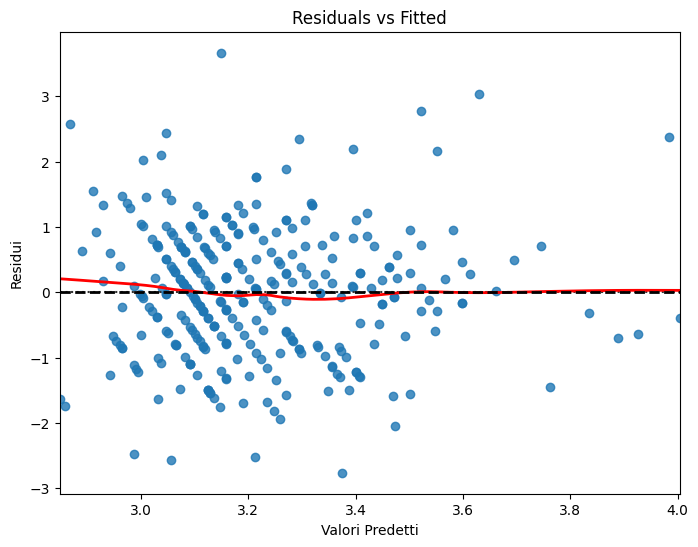

In [ ]:
residui = modello_età_2.resid

# Varianza dei residui
residui_std = np.std(residui)

# Residui studentizzati
residui_studentized = residui / residui_std

valori_predetti = modello_età_2.fittedvalues

plt.figure(figsize=(8,6))
sns.residplot(x=valori_predetti, y=residui_studentized, lowess=True, line_kws={"color": "red", "lw": 2})
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel("Valori Predetti")
plt.ylabel("Residui")
plt.title("Residuals vs Fitted")
plt.show()

Scale-location Plot

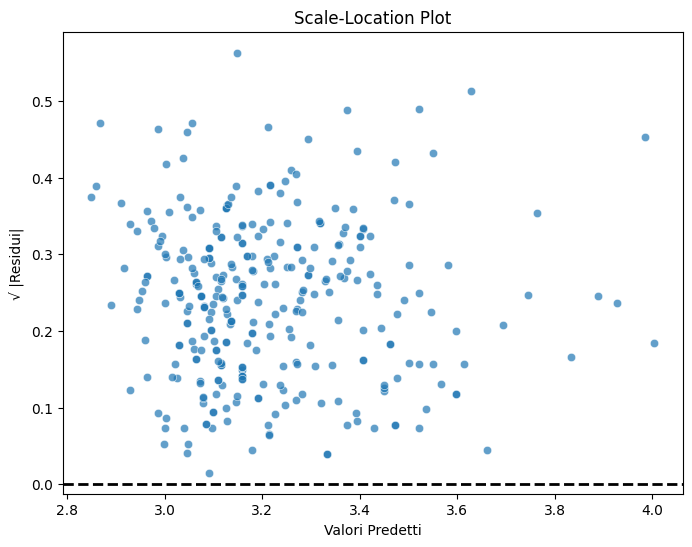

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=valori_predetti, y=np.sqrt(np.abs(residui)), alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', lw=2)
plt.xlabel("Valori Predetti")
plt.ylabel("√ |Residui|")
plt.title("Scale-Location Plot")
plt.show()

Verifica Ouliers e punti di Leverage

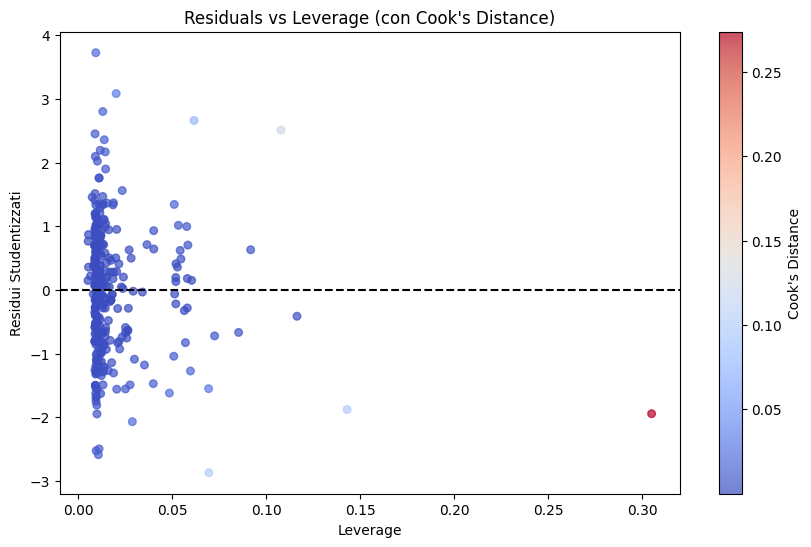

In [ ]:
# Leverage e i residui studentizzati
influence = modello_età_2.get_influence()
leverage = influence.hat_matrix_diag
resid_studentized = influence.resid_studentized_external
cooks_d = influence.cooks_distance[0]

# Soglia per identificare outliers basata sulla Cook's Distance
threshold_cooks = 4 / len(X)  # Formula per identificare outlier influenti
threshold_leverage = 2 * (X.shape[1] / len(X))  # Soglia per la leverage
threshold_resid = 3  # Outlier residui studentizzati oltre ±3

# Figura
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot
sc = ax.scatter(leverage, resid_studentized, s=30, c=cooks_d, cmap='coolwarm', alpha=0.7)
plt.axhline(y=0, linestyle='--', color='black', linewidth=1.5)

# Nuovo ciclo che mostra solo le etichette con leverage > threshold e residuo > 3
for i, (lev, res) in enumerate(zip(leverage, resid_studentized)):
    # Condizione per leverage > threshold e residuo > 3
    if lev > threshold_leverage and res > 3:
        ax.annotate(f'{i}', (lev, res), fontsize=9, color='black', xytext=(5, 5), textcoords='offset points')

# Titoli e etichette
plt.xlabel("Leverage")
plt.ylabel("Residui Studentizzati")
plt.title("Residuals vs Leverage (con Cook's Distance)")
cbar = plt.colorbar(sc)
cbar.set_label("Cook's Distance")

plt.show()

Normal Q-Q Plot

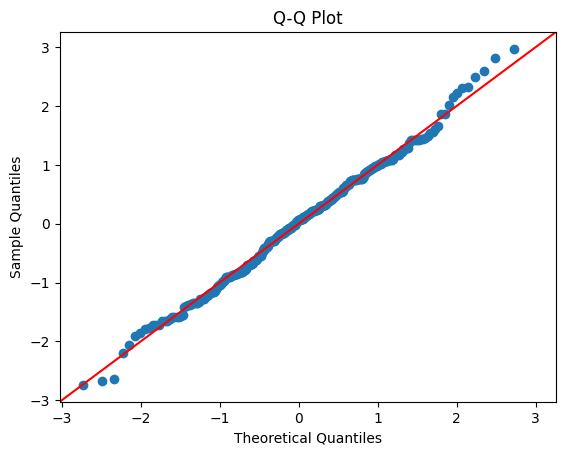

Statistic test: 0.9952874216302208, p-value: 0.46900328216817444
I residui seguono una distribuzione normale (non rifiutiamo H0).


In [ ]:
# Identificazione degli indici outlier
outlier_indices = np.where((np.abs(resid_studentized) > threshold_resid) | (leverage > threshold_leverage))[0]

# Filtrare i residui per rimuovere gli outlier
residui_clean = np.delete(resid_studentized, outlier_indices)

# QQ plot
sm.qqplot(residui_clean, line='45', fit=True)
plt.title("Q-Q Plot")
plt.show()

# Test di Shapiro-Wilk per la normalità dei residui studentizzati
stat, p_value = stats.shapiro(residui_clean)

print(f"Statistic test: {stat}, p-value: {p_value}")

# Interpretazione
if p_value > 0.05:
    print("I residui seguono una distribuzione normale (non rifiutiamo H0).")
else:
    print("I residui non seguono una distribuzione normale (rifiutiamo H0 del test Shapiro Wilk).")


## 3. Quali sono i principali fattori ambientali che influenzano la mortalità nella popolazione anziana (65+)?

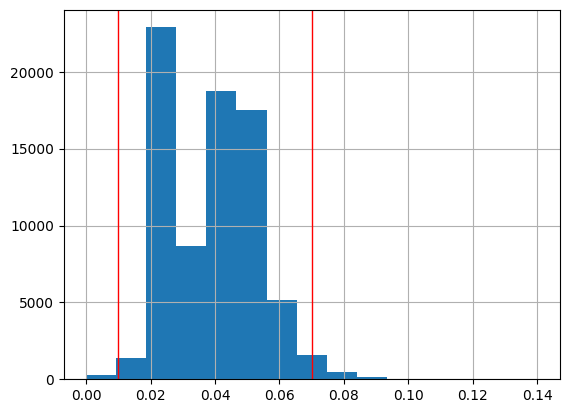

In [ ]:
# Calcolo del 98° percentile
percentile_98 = np.percentile(df_annuale['Tasso di mortalità 65+'], 98)

# Calcolo del 2° percentile
percentile_2 = np.percentile(df_annuale['Tasso di mortalità 65+'], 2)
df_annuale['Tasso di mortalità 65+'].hist(bins=15)
plt.axvline(percentile_98, color='red', linewidth=1)
plt.axvline(percentile_2, color='red', linewidth=1)
plt.show()

In [ ]:
# Creazione della matrice X con costante
X = sm.add_constant(df_annuale[variabili_ambientali])

### Mortalità 98%

In [ ]:
# Creazione della variabile binaria
df_annuale['Tasso di mortalità 65+ alto'] = (df_annuale['Tasso di mortalità 65+'] >= percentile_98).astype(int)

# Variabile dipendente
y_98 = df_annuale['Tasso di mortalità 65+ alto']

# Stima del modello Logit
modello_logit_98 = sm.Logit(y_98, X)
risultati98 = modello_logit_98.fit()

# Stampa dei risultati
print(risultati98.summary())


Optimization terminated successfully.
         Current function value: 0.113729
         Iterations 9
                                Logit Regression Results                               
Dep. Variable:     Tasso di mortalità 65+ alto   No. Observations:                77040
Model:                                   Logit   Df Residuals:                    77030
Method:                                    MLE   Df Model:                            9
Date:                         Wed, 19 Mar 2025   Pseudo R-squ.:                  0.1770
Time:                                 10:46:19   Log-Likelihood:                -8761.7
converged:                                True   LL-Null:                       -10646.
Covariance Type:                     nonrobust   LLR p-value:                     0.000
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

#### Modello Ridotto

Optimization terminated successfully.
         Current function value: 0.113740
         Iterations 9
                                Logit Regression Results                               
Dep. Variable:     Tasso di mortalità 65+ alto   No. Observations:                77040
Model:                                   Logit   Df Residuals:                    77032
Method:                                    MLE   Df Model:                            7
Date:                         Wed, 19 Mar 2025   Pseudo R-squ.:                  0.1769
Time:                                 10:46:20   Log-Likelihood:                -8762.5
converged:                                True   LL-Null:                       -10646.
Covariance Type:                     nonrobust   LLR p-value:                     0.000
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------

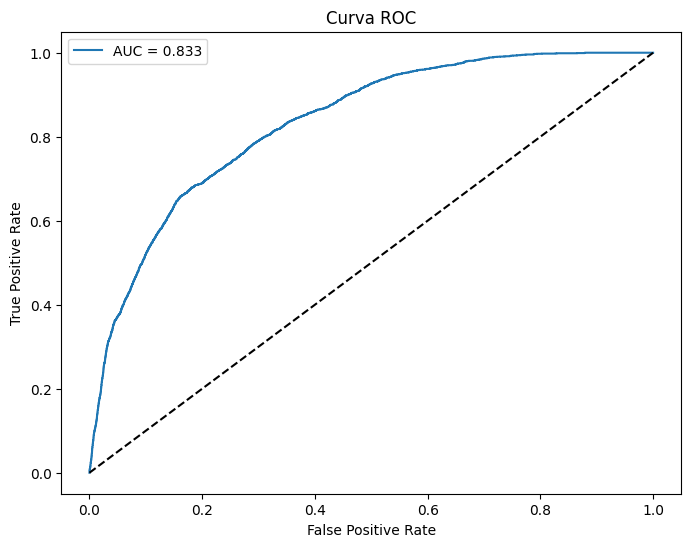

In [ ]:
# Riduzione variabili
X_98 = X.drop(columns=['% Aree a Pericolosità idraulica elevata','Precipitazioni medie annuali'])

# Stima del modello Logit
modello_logit98 = sm.Logit(y_98, X_98)
risultati_nuovi98 = modello_logit98.fit()

# Stampa dei risultati
print(risultati_nuovi98.summary())

# Calcolo del VIF per ogni variabile
vif98 = pd.DataFrame()
vif98['Variabile'] = X_98.columns
vif98['VIF'] = [variance_inflation_factor(X_98.values, i) for i in range(X_98.shape[1])]

# Risultati
print()
print('\033[1mVIF\033[0m')
print(vif98)


# Odds ratio (OR) esponenziando i coefficienti
odds_ratios98 = np.exp(risultati_nuovi98.params)

print()
print('\033[1mOdds ratios\033[0m')
print(odds_ratios98)

# Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni delle probabilità
y_pred_prob98 = risultati_nuovi98.predict(X_98)

# Calcolo ROC curve
fpr, tpr, _ = roc_curve(y_98, y_pred_prob98)
auc_score = roc_auc_score(y_98, y_pred_prob98)

# Plot della curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')  # Linea diagonale casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

### Mortalità 2%

In [ ]:
# Creazione della variabile binaria
df_annuale['Tasso di mortalità 65+ basso'] = (df_annuale['Tasso di mortalità 65+'] <= percentile_2).astype(int)

# Variabile dipendente
y_2 = df_annuale['Tasso di mortalità 65+ basso']

# Stima del modello Logit
modello_logit2 = sm.Logit(y_2, X)
risultati2 = modello_logit2.fit()

# Stampa dei risultati
print(risultati2.summary())

Optimization terminated successfully.
         Current function value: 0.083258
         Iterations 10
                                Logit Regression Results                                
Dep. Variable:     Tasso di mortalità 65+ basso   No. Observations:                77040
Model:                                    Logit   Df Residuals:                    77030
Method:                                     MLE   Df Model:                            9
Date:                          Wed, 19 Mar 2025   Pseudo R-squ.:                  0.1933
Time:                                  10:46:21   Log-Likelihood:                -6414.2
converged:                                 True   LL-Null:                       -7951.1
Covariance Type:                      nonrobust   LLR p-value:                     0.000
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------


VIF
                                           Variabile          VIF
0                                              const  1489.418899
1        Valore massimo dell'accelerazione del suolo     1.202148
2                                     Altitudine (m)     5.202696
3                       Precipitazioni medie annuali     2.060031
4               Incremento temperatura media annuale     1.113960
5                        Temperature massime annuali     6.145263
6                                 Escursione termica     1.214107
7            % Aree a Pericolosità idraulica elevata     1.253593
8                      Superficie territoriale (kmq)     1.089354
9  % Area a Pericolosità da frana PAI molto eleva...     2.556553

Odds ratios
const                                                         39.833952
Valore massimo dell'accelerazione del suolo                    0.986997
Altitudine (m)                                                 0.999427
Precipitazioni medie annuali            

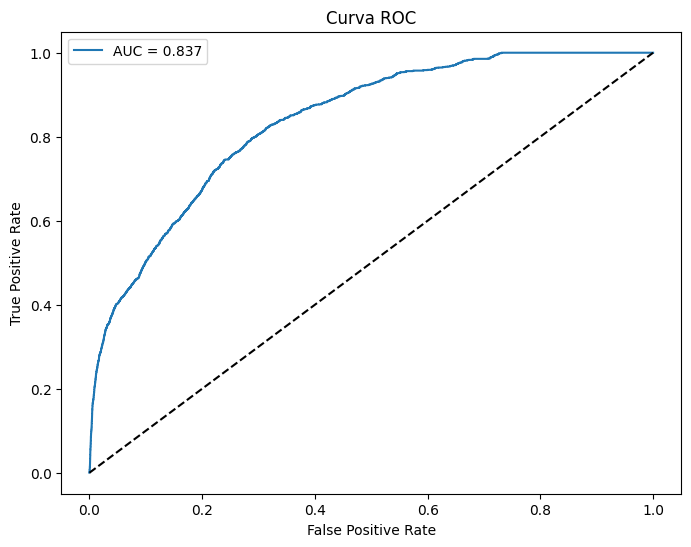

In [ ]:
# Calcolo del VIF per ogni variabile
vif2 = pd.DataFrame()
vif2['Variabile'] = X.columns
vif2['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Visualizzazione i risultati
print()
print('\033[1mVIF\033[0m')
print(vif2)

# Odds ratio (OR) esponenziando i coefficienti
odds_ratios2 = np.exp(risultati2.params)

print()
print('\033[1mOdds ratios\033[0m')
print(odds_ratios2)

# Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Predizioni delle probabilità
y_pred_prob2 = risultati2.predict(X)

# Calcolo ROC curve
fpr, tpr, _ = roc_curve(y_2, y_pred_prob2)
auc_score = roc_auc_score(y_2, y_pred_prob2)

# Plot della curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0,1], [0,1], 'k--')  # Linea diagonale casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

## 4. Quali comuni sono maggiormente esposti ai rischi naturali?

Creazione indicatore score Rischio Ambientale

In [ ]:
# Definizione delle variabili e della loro direzione di rischio
variabili_unidirezionali = ['Incremento temperatura media annuale', 'Mesi_caldi','Mesi_freddi',
                            "Valore massimo dell'accelerazione del suolo",
                            '% Aree a Pericolosità idraulica elevata', "Grandi_piogge","Siccità",
                            '% Area a Pericolosità da frana PAI molto elevata e elevata']

# Creazione di un DataFrame con solo le colonne rilevanti
df_rischio = df_comuni[['Nome_Unità_Territoriale'] + variabili_unidirezionali].copy()

# Calcolo dello Z-score per tutte le variabili
df_rischio[variabili_unidirezionali] = df_rischio[variabili_unidirezionali].apply(zscore)

# Per le variabili unidirezionali, consideriamo solo gli z-score positivi (i negativi diventano 0)
df_rischio[variabili_unidirezionali] = df_rischio[variabili_unidirezionali].clip(lower=0)

# Calcolo dello score di rischio ambientale sommando i valori normalizzati
df_rischio['Score_Rischio_Ambientale'] = df_rischio[variabili_unidirezionali].sum(axis=1)

# Ordiniamento dei comuni in base al punteggio di rischio
print(df_rischio[['Nome_Unità_Territoriale','Score_Rischio_Ambientale']].sort_values(by="Score_Rischio_Ambientale", ascending=False))

    Nome_Unità_Territoriale  Score_Rischio_Ambientale
176     MONCHIO DELLE CORTI                  9.731501
119                FIUMALBO                  9.355156
212             PIEVEPELAGO                  9.238345
109                  FANANO                  9.063340
152    LIZZANO IN BELVEDERE                  8.097941
..                      ...                       ...
295            TRAVERSETOLO                  0.121744
97                  COPPARO                  0.065324
93                COMACCHIO                  0.065324
161              MARZABOTTO                  0.030049
148               LAGOSANTO                  0.012612

[321 rows x 2 columns]


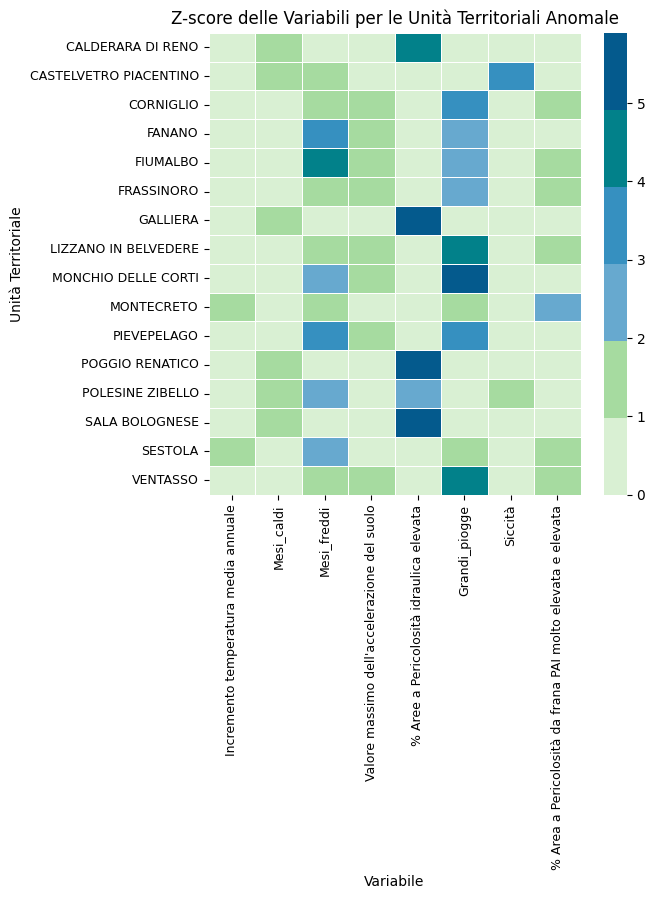

In [ ]:
# Definizione della scala cromatica personalizzata
custom_palette = ["#045A8D", "#02818A", "#3690C0", "#67A9CF", "#A6DBA0", "#D9F0D3"]
custom_palette = custom_palette[::-1]

comuni_a_rischio = df_rischio[df_rischio['Score_Rischio_Ambientale']> 7]

plt.figure(figsize=(6, 6))
sns.heatmap(
    comuni_a_rischio[variabili_unidirezionali],
    annot=False,
    cmap=custom_palette,
    linewidths=0.5,
    yticklabels=comuni_a_rischio['Nome_Unità_Territoriale']
)
plt.title("Z-score delle Variabili per le Unità Territoriali Anomale")
plt.xlabel("Variabile")
plt.ylabel("Unità Territoriale")
plt.yticks(rotation=0, size=9)
plt.xticks(rotation=90, size=9)
plt.show()